<a href="https://colab.research.google.com/github/Open-Catalyst-Project/ocp/blob/tutorials_01_11/tutorials/OCP_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir("/l/users/elizaveta.starykh/OCP_project/ocp-git/")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
print(sys.version)
import torch
print(torch.__version__)

3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) 
[GCC 12.3.0]
2.0.1+cu118


In [5]:
import matplotlib
matplotlib.use('Agg')

import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'font.family': ' DejaVu Sans',
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'axes.labelsize': 25,
   'axes.titlesize': 25,
   'text.usetex': False,
   'figure.figsize': [12, 12]
}
matplotlib.rcParams.update(params)


import ase.io
from ase.io.trajectory import Trajectory
from ase.io import extxyz
from ase.calculators.emt import EMT
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import LBFGS
from ase.visualize.plot import plot_atoms
from ase import Atoms
from IPython.display import Image


from ocpmodels.trainers import OCPTrainer
from ocpmodels.datasets import LmdbDataset
from ocpmodels import models
from ocpmodels.common import logger
from ocpmodels.common.utils import setup_logging, setup_imports
setup_logging()
setup_imports()

import numpy as np
import copy
import os

import torch
from ocpmodels.datasets import LmdbDataset

### Interacting with the OC20 datasets

The OC20 datasets are stored in LMDBs. Here we show how to interact with the datasets directly in order to better understand the data. We use [LmdbDataset](https://github.com/Open-Catalyst-Project/ocp/blob/main/ocpmodels/datasets/lmdb_dataset.py) to read in a directory of LMDB files or a single LMDB file.

In [6]:
# LmdbDataset is our custom Dataset method to read the lmdbs as Data objects. Note that we need to give the path to the folder containing lmdbs for S2EF
dataset = LmdbDataset({"src": "./tutorial_data/s2ef/train_100/"})

print("Size of the dataset created:", len(dataset))
print(dataset[0])

Size of the dataset created: 100
Data(edge_index=[2, 2964], y=6.282500615000004, pos=[86, 3], cell=[1, 3, 3], atomic_numbers=[86], natoms=86, cell_offsets=[2964, 3], force=[86, 3], fixed=[86], tags=[86], sid=[1], fid=[1], total_frames=74, id='0_0')


In [5]:
data = dataset[0]
data

Data(edge_index=[2, 2964], y=6.282500615000004, pos=[86, 3], cell=[1, 3, 3], atomic_numbers=[86], natoms=86, cell_offsets=[2964, 3], force=[86, 3], fixed=[86], tags=[86], sid=[1], fid=[1], total_frames=74, id='0_0')

In [6]:
energies = torch.tensor([data.y for data in dataset])
energies

tensor([ 6.2825e+00,  4.1290e+00,  3.1451e+00,  3.0260e+00,  1.7921e+00,
         1.6451e+00,  1.2257e+00,  1.2161e+00,  1.0712e+00,  7.4727e-01,
         5.9575e-01,  5.7016e-01,  4.2819e-01,  3.1616e-01,  2.5283e-01,
         2.2425e-01,  2.2346e-01,  2.0530e-01,  1.6090e-01,  1.1807e-01,
         1.1691e-01,  9.1254e-02,  7.4997e-02,  6.3274e-02,  5.2782e-02,
         4.8892e-02,  3.9609e-02,  3.1746e-02,  2.7179e-02,  2.7007e-02,
         2.3709e-02,  1.8005e-02,  1.7676e-02,  1.4129e-02,  1.3162e-02,
         1.1374e-02,  7.4124e-03,  7.7525e-03,  6.1224e-03,  5.2787e-03,
         2.8587e-03,  1.1835e-04, -1.1200e-03, -1.3011e-03, -2.6812e-03,
        -5.9202e-03, -6.1644e-03, -6.9261e-03, -9.1364e-03, -9.2114e-03,
        -1.0665e-02, -1.3760e-02, -1.3588e-02, -1.4895e-02, -1.6190e-02,
        -1.8660e-02, -1.4980e-02, -1.8880e-02, -2.0218e-02, -2.0559e-02,
        -2.1013e-02, -2.2129e-02, -2.2748e-02, -2.3322e-02, -2.3382e-02,
        -2.3865e-02, -2.3973e-02, -2.4196e-02, -2.4

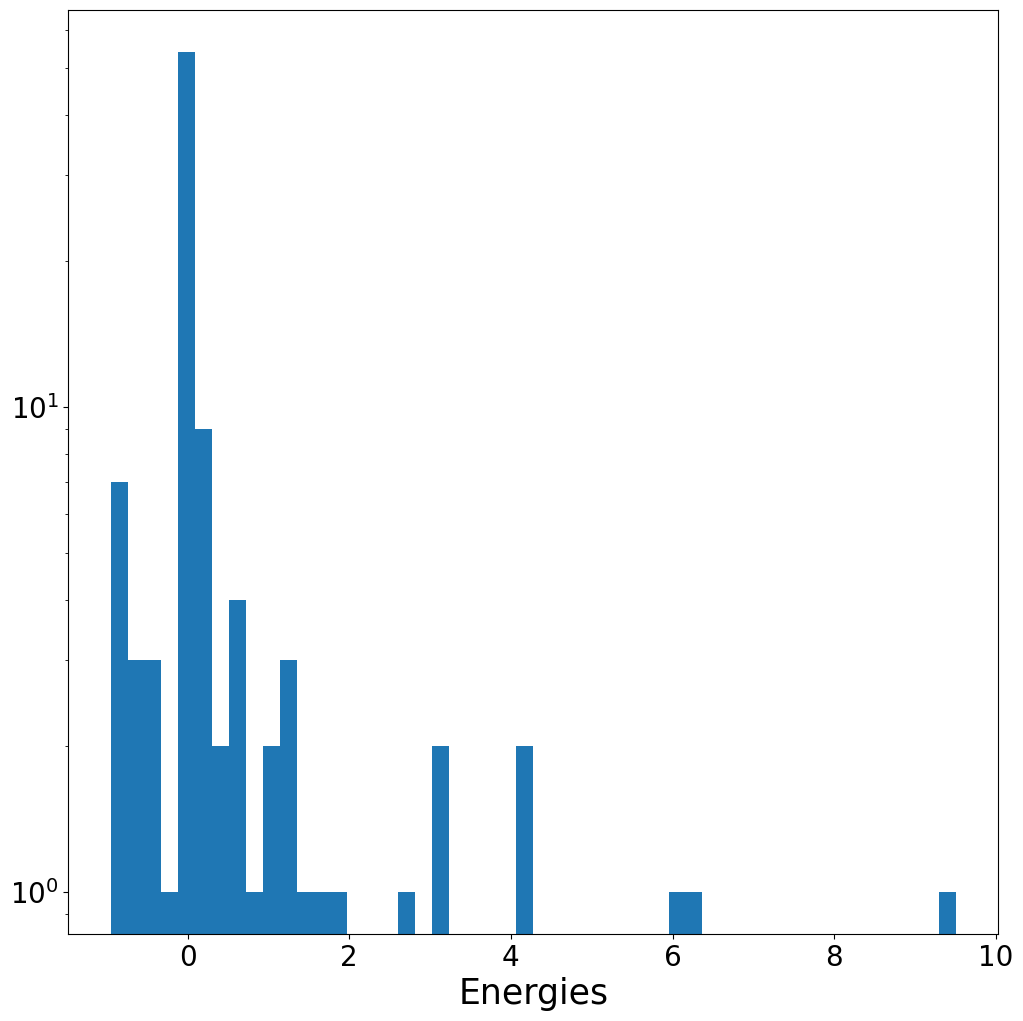

In [7]:
plt.hist(energies, bins = 50)
plt.yscale("log")
plt.xlabel("Energies")
plt.show()

### Additional Resources

More helpful resources, tutorials, and documentation can be found at ASE's webpage: https://wiki.fysik.dtu.dk/ase/index.html. We point to specific pages that may be of interest:

* Interacting with Atoms Object: https://wiki.fysik.dtu.dk/ase/ase/atoms.html
* Visualization: https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html
* Structure optimization: https://wiki.fysik.dtu.dk/ase/ase/optimize.html
* More ASE Tutorials: https://wiki.fysik.dtu.dk/ase/tutorials/tutorials.html

<a name="tasks"></a>
# Tasks



## Structure to Energy and Forces (S2EF) <a name="s2ef"></a>

The S2EF task takes an atomic system as input and predicts the energy of the entire system and forces on each atom. This is our most general task, ultimately serving as a surrogate to DFT. A model that can perform well on this task can accelerate other applications like molecular dynamics and transitions tate calculations.

### Steps for training an S2EF model
1) Define or load a configuration (config), which includes the following
* task
* model
* optimizer
* dataset
* trainer

2) Create a ForcesTrainer object

3) Train the model

4) Validate the model

**For storage and compute reasons we use a very small subset of the OC20 S2EF dataset for this tutorial. Results will be considerably worse than presented in our paper.**

### Dataset

In [6]:
!pwd

/l/users/elizaveta.starykh/OCP_project/ocp-git


In [7]:
### Train on tutorial dataset - no efermi

# train_src = "tutorial_data/s2ef/train_100"
# val_src = "tutorial_data/s2ef/val_20"


### Train on 170k, validation is on the subset of 20k, efermi included

train_src = "./data/s2ef/200k/train/output_lmdb/normalized_efermi"
val_src = "./data/s2ef/200k/train/output_lmdb/normalized_efermi/train_20000_systems"


### Normalize data

If you wish to normalize the targets we must compute the mean and standard deviation for our energy values. Because forces are physically related by the negative gradient of energy, we use the same multiplicative energy factor for forces.

In [8]:
train_dataset = LmdbDataset({"src": train_src})


In [9]:

energies = []
for data in train_dataset:
    energies.append(data.y)


#### for tutorial_data/s2ef/train_100 dataset:
#### mean  = 0.45158625849998374 
#### stdev = 1.5156444102461508


mean = np.mean(energies)
stdev = np.std(energies)

In [10]:
print(mean, stdev)

-0.7877437496095779 2.8471219290033876


### Define the Config

For this example, we will explicitly define the config; however, a set of default configs can be found [here](https://github.com/Open-Catalyst-Project/ocp/tree/master/configs). Default config yaml files can easily be loaded with the following [utility](https://github.com/Open-Catalyst-Project/ocp/blob/aa8e44d50229fce887b3a94a5661c4f85cd73eed/ocpmodels/common/utils.py#L361-L400). Loading a yaml config is preferrable when launching jobs from the command line. We have included our best models' config files here for reference. 

**Note** - we only train for a single epoch with a reduced batch size (GPU memory constraints) for demonstration purposes, modify accordingly for full convergence.

In [8]:
### Define sweep configuration
from pprint import pprint
import wandb

sweep_configuration = {
    "method": "random",
    "name": "sweep-PaiNN-train-170k",
    "metric": {"goal": "minimize", "name": "loss"},
    "parameters": {
        "batch_size": {"values": [8, 16, 32, 64]},  ### given
        # "batch_size": {"values": [1, 2, 8]},
        # "batch_size": {"value": 1},
        # "epochs": {"values": [5, 10, 15]},   ### given
        "epochs": {"value": 1},
        # "lr" : {"value": 1}
        "lr": {
            "distribution": "log_uniform_values",
            "max": 1e-3, 
            "min": 5e-5 },
        "efermi_repr_length": { "values": [32, 64, 128, 256] },
    },
}


pprint(sweep_configuration)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'name': 'sweep-PaiNN-train-170k',
 'parameters': {'batch_size': {'values': [8, 16, 32, 64]},
                'efermi_repr_length': {'values': [32, 64, 128, 256]},
                'epochs': {'value': 1},
                'lr': {'distribution': 'log_uniform_values',
                       'max': 0.001,
                       'min': 5e-05}}}


In [9]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="PaiNN-170k-efermi")

2024-05-28 22:51:12 (ERROR): Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 5i5pgmb2
Sweep URL: https://wandb.ai/ml-mbzuai/PaiNN-170k-efermi/sweeps/5i5pgmb2


In [10]:
import yaml

def sweep_model(hidden_channels_sweep = 512, efermi_repr_length_sweep=64):

    with open('configs/oc22/s2ef/painn/painn.yml', 'r') as file:
        model = yaml.safe_load(file)

    model = model["model"]
    model['name'] = 'ocpmodels.models.painn.painn.PaiNN'
    model['hidden_channels'] = hidden_channels_sweep
    model['efermi_length'] = efermi_repr_length_sweep

    return model


In [12]:
test_sweep_model = sweep_model(efermi_repr_length_sweep=256)
print(test_sweep_model)

{'name': 'ocpmodels.models.painn.painn.PaiNN', 'hidden_channels': 512, 'num_layers': 6, 'num_rbf': 128, 'cutoff': 12.0, 'max_neighbors': 50, 'scale_file': 'configs/oc22/s2ef/painn/nb6_h512_n50_c12_oc22.pt', 'regress_forces': True, 'direct_forces': True, 'use_pbc': True, 'otf_graph': True, 'efermi_length': 256}


In [29]:
import yaml

# Model
# /configs/oc22/s2ef/painn

with open('configs/oc22/s2ef/painn/painn.yml', 'r') as file:
    model = yaml.safe_load(file)

model = model["model"]
model['name'] = 'ocpmodels.models.painn.painn.PaiNN'
model['hidden_channels'] = 512
# model['checkpoint_every'] = 1000
model['efermi_length'] = 32

model

{'name': 'ocpmodels.models.painn.painn.PaiNN',
 'hidden_channels': 512,
 'num_layers': 6,
 'num_rbf': 128,
 'cutoff': 12.0,
 'max_neighbors': 50,
 'scale_file': 'configs/oc22/s2ef/painn/nb6_h512_n50_c12_oc22.pt',
 'regress_forces': True,
 'direct_forces': True,
 'use_pbc': True,
 'otf_graph': True}

In [11]:
# Task
task = {
    'dataset': 'lmdb', # dataset used for the S2EF task
    'description': 'Regressing to energies and forces for DFT trajectories from OCP',
    'type': 'regression',
    'metric': 'mae',
    'labels': ['potential energy'],
    'grad_input': 'atomic forces',
    'train_on_free_atoms': True,
    'eval_on_free_atoms': True
}

# Dataset
# stdev, mean = (2.8471219290033876, -0.7877437496095779) -- for 170k+efermi dataset
dataset = [
    {'src': train_src,
    'normalize_labels': True,
    #  "target_mean": mean,
    "target_mean": -0.7877437496095779,
    #  "target_std": stdev,
    "target_std": 2.8471219290033876,
    "grad_target_mean": 0.0,
    #  "grad_target_std": stdev
    "grad_target_std": 2.8471219290033876
    }, # train set
    {'src': val_src}, # val set (optional)
    ]
# (-0.7877437496095779 2.8471219290033876)  -- for 170k+efermi dataset
# (2.8392264933285123, -0.7946160068500009)  -- for tutorial_dataset 100 systems

In [12]:
def sweep_optimizer(batch_size_sweep=1, epoch_sweep=1, learning_rate_sweep=5.e-4):

  # Optimizer
  optimizer = {
      'batch_size': batch_size_sweep,         # originally 32
      'eval_batch_size': batch_size_sweep,    # originally 32
      'num_workers': 2,
      'lr_initial': learning_rate_sweep,
      'optimizer': 'AdamW',
      'optimizer_params': {"amsgrad": True},
      'scheduler': "ReduceLROnPlateau",
      'mode': "min",
      'factor': 0.8,
      'patience': 3,
      'max_epochs': epoch_sweep,         # used for demonstration purposes
      'force_coefficient': 100,
      'ema_decay': 0.999,
      'clip_grad_norm': 10,
      'loss_energy': 'mae',
      'loss_force': 'l2mae',
  }

  return optimizer

In [47]:
test_sweep_optimizer = sweep_optimizer(epoch_sweep=2)
print(test_sweep_optimizer)

{'batch_size': 1, 'eval_batch_size': 1, 'num_workers': 2, 'lr_initial': 0.0005, 'optimizer': 'AdamW', 'optimizer_params': {'amsgrad': True}, 'scheduler': 'ReduceLROnPlateau', 'mode': 'min', 'factor': 0.8, 'patience': 3, 'max_epochs': 2, 'force_coefficient': 100, 'ema_decay': 0.999, 'clip_grad_norm': 10, 'loss_energy': 'mae', 'loss_force': 'l2mae'}


In [ ]:
# sweep_id_test = wandb.sweep(sweep=sweep_configuration, project="Trial-project")

# # def test_sweep():
# #     with wandb.init(project="Trial-project", config = sweep_configuration):
# #         config_tst = wandb.config
# #         for epoch in range(config_tst.epochs): 
# #             print("\n\tEPOCHS\n", epoch, '\n')

# run_test = wandb.init(config=sweep_configuration, id=sweep_id_test)

# # wandb.agent(sweep_id, test_sweep, count=5)


In [ ]:
# wandb.config.get("epochs")

In [13]:
def train_wandb(config=None):
    with wandb.init(project="PaiNN-170k-efermi", config = sweep_configuration):
        config = wandb.config
        
        epoch = config.epochs
        print("!*!*! epoch: ", epoch)
        batch_size = config['batch_size']
        learning_rate = config["lr"]
        efermi_length = config['efermi_repr_length']
        optimizer = sweep_optimizer(batch_size_sweep=batch_size, 
                                    epoch_sweep=epoch, 
                                    learning_rate_sweep=learning_rate)
        model = sweep_model(efermi_repr_length_sweep=efermi_length)
        
        # print("!!! epochs: ", epoch)

        trainer = OCPTrainer(
            task=task,
            model=copy.deepcopy(model), # copied for later use, not necessary in practice.
            dataset=dataset,
            optimizer=optimizer,
            # optimizer=sweep_optimizer(batch_size_sweep=batch_size, 
            #                     epoch_sweep=i, 
            #                     learning_rate_sweep=learning_rate),
            outputs={},
            loss_fns={},
            eval_metrics={},
            name="s2ef",
            identifier="S2EF-170k-efermi",
            run_dir=".", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
            is_debug=False, # if True, do not save checkpoint, logs, or results
            print_every=5,
            seed=0, # random seed to use
            logger="wandb", # logger of choice (tensorboard and wandb supported)
            local_rank=0,
            amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
        )
        # print("!!!\t In final config file: ", optimizer['max_epochs'])
        trainer.train()

        # avg_loss = trainer.final_loss
        # avg_loss = trainer.metrics['loss']
        # wandb.log({"loss": avg_loss, "epoch": epoch, "learning rate": learning_rate, "batch size": batch_size}) 

In [14]:
wandb.agent(sweep_id, train_wandb, count=30)

2024-05-28 22:51:55 (INFO): Starting sweep agent: entity=None, project=None, count=30


wandb: Agent Starting Run: ibva3wba with config:
wandb: 	batch_size: 32
wandb: 	efermi_repr_length: 256
wandb: 	epochs: 1
wandb: 	lr: 0.0009559819585070726
2024-05-28 22:51:56 (ERROR): Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml-mbzuai (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


!*!*! epoch:  1


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
2024-05-28 22:52:22 (WARNING): Detected old config, converting to new format. Consider updating to avoid potential incompatibilities.


2024-05-28 22:52:22 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2024-05-28-22-52-48-S2EF-170k-efermi
  commit: null
  identifier: S2EF-170k-efermi
  logs_dir: ./logs/wandb/2024-05-28-22-52-48-S2EF-170k-efermi
  print_every: 5
  results_dir: ./results/2024-05-28-22-52-48-S2EF-170k-efermi
  seed: 0
  timestamp_id: 2024-05-28-22-52-48-S2EF-170k-efermi
dataset:
  format: lmdb
  grad_target_mean: 0.0
  grad_target_std: 2.8471219290033876
  key_mapping:
    force: forces
    y: energy
  normalize_labels: true
  src: ./data/s2ef/200k/train/output_lmdb/normalized_efermi
  target_mean: -0.7877437496095779
  target_std: 2.8471219290033876
  transforms:
    normalizer:
      energy:
        mean: -0.7877437496095779
        stdev: 2.8471219290033876
      forces:
        mean: 0.0
        stdev: 2.8471219290033876
eval_metrics:
  metrics:
    energy:
    - mae
    forces:
    - forcesx_mae
    - forcesy_mae
    - forcesz_mae
    - mae
    - cosine_similarity
    - magnitude_error
    m

wandb: WARNING Ignored wandb.init() arg id when running a sweep


wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2024-05-28 22:52:29 (INFO): Loading dataset: lmdb
2024-05-28 22:52:29 (INFO): Batch balancing is disabled for single GPU training.
2024-05-28 22:52:30 (INFO): Batch balancing is disabled for single GPU training.
2024-05-28 22:52:30 (INFO): Loading model: ocpmodels.models.painn.painn.PaiNN


/l/users/elizaveta.starykh/conda_envs/python9/lib/python3.9/site-packages/torch_geometric/nn/conv/message_passing.py:988: UserWarning: 'PaiNNMessage.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "


2024-05-28 22:52:31 (INFO): Loaded PaiNN with 20052745 parameters.
2024-05-28 22:52:42 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.54e+02, forcesx_mae: 7.50e-02, forcesy_mae: 8.83e-02, forcesz_mae: 1.07e-01, forces_mae: 9.00e-02, forces_cosine_similarity: 1.10e-02, forces_magnitude_error: 1.40e-01, loss: 2.62e+02, lr: 9.56e-04, epoch: 9.09e-04, step: 5.00e+00
2024-05-28 22:52:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.87e+02, forcesx_mae: 1.00e-01, forcesy_mae: 1.30e-01, forcesz_mae: 1.46e-01, forces_mae: 1.25e-01, forces_cosine_similarity: 2.64e-02, forces_magnitude_error: 2.09e-01, loss: 2.90e+02, lr: 9.56e-04, epoch: 1.82e-03, step: 1.00e+01
2024-05-28 22:52:45 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.65e+03, forcesx_mae: 3.51e-01, forcesy_mae: 4.17e-01, forcesz_mae: 7.32e-01, forces_mae: 5.00e-01, forces_cosine_similarity: -1.38e-02, forces_magnitude_error: 9.18e-01, loss: 1.87e+03, lr: 9.56e-04, epoch: 2.73e-03, st

2024-05-28 22:55:49 (WARNING): Found nans while computing loss
2024-05-28 22:55:49 (WARNING): Found nans while computing loss
2024-05-28 22:55:49 (WARNING): Found nans while computing loss
2024-05-28 22:55:49 (WARNING): Found nans while computing loss
2024-05-28 22:55:49 (WARNING): Found nans while computing loss
2024-05-28 22:55:49 (WARNING): Found nans while computing loss


2024-05-28 22:55:49 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.43e+05, lr: 9.56e-04, epoch: 1.44e-01, step: 7.90e+02


2024-05-28 22:55:49 (WARNING): Found nans while computing loss
2024-05-28 22:55:49 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss
2024-05-28 22:55:50 (WARNING): Found nans while computing loss


2024-05-28 22:55:50 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.17e+05, lr: 9.56e-04, epoch: 1.45e-01, step: 7.95e+02


2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss
2024-05-28 22:55:51 (WARNING): Found nans while computing loss


2024-05-28 22:55:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.00e+05, lr: 9.56e-04, epoch: 1.45e-01, step: 8.00e+02


2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:52 (WARNING): Found nans while computing loss
2024-05-28 22:55:53 (WARNING): Found nans while computing loss
2024-05-28 22:55:53 (WARNING): Found nans while computing loss


2024-05-28 22:55:53 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.71e+05, lr: 9.56e-04, epoch: 1.46e-01, step: 8.05e+02


2024-05-28 22:55:53 (WARNING): Found nans while computing loss
2024-05-28 22:55:53 (WARNING): Found nans while computing loss
2024-05-28 22:55:53 (WARNING): Found nans while computing loss
2024-05-28 22:55:53 (WARNING): Found nans while computing loss
2024-05-28 22:55:53 (WARNING): Found nans while computing loss
2024-05-28 22:55:53 (WARNING): Found nans while computing loss
2024-05-28 22:55:54 (WARNING): Found nans while computing loss
2024-05-28 22:55:54 (WARNING): Found nans while computing loss
2024-05-28 22:55:54 (WARNING): Found nans while computing loss
2024-05-28 22:55:54 (WARNING): Found nans while computing loss


2024-05-28 22:55:54 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.15e+05, lr: 9.56e-04, epoch: 1.47e-01, step: 8.10e+02


2024-05-28 22:55:54 (WARNING): Found nans while computing loss
2024-05-28 22:55:54 (WARNING): Found nans while computing loss
2024-05-28 22:55:54 (WARNING): Found nans while computing loss
2024-05-28 22:55:54 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss


2024-05-28 22:55:55 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.50e+05, lr: 9.56e-04, epoch: 1.48e-01, step: 8.15e+02


2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:55 (WARNING): Found nans while computing loss
2024-05-28 22:55:56 (WARNING): Found nans while computing loss
2024-05-28 22:55:56 (WARNING): Found nans while computing loss
2024-05-28 22:55:56 (WARNING): Found nans while computing loss
2024-05-28 22:55:56 (WARNING): Found nans while computing loss
2024-05-28 22:55:56 (WARNING): Found nans while computing loss
2024-05-28 22:55:56 (WARNING): Found nans while computing loss


2024-05-28 22:55:56 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.55e+05, lr: 9.56e-04, epoch: 1.49e-01, step: 8.20e+02


2024-05-28 22:55:56 (WARNING): Found nans while computing loss
2024-05-28 22:55:56 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss
2024-05-28 22:55:57 (WARNING): Found nans while computing loss


2024-05-28 22:55:58 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.48e+05, lr: 9.56e-04, epoch: 1.50e-01, step: 8.25e+02


2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:58 (WARNING): Found nans while computing loss
2024-05-28 22:55:59 (WARNING): Found nans while computing loss
2024-05-28 22:55:59 (WARNING): Found nans while computing loss


2024-05-28 22:55:59 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.78e+05, lr: 9.56e-04, epoch: 1.51e-01, step: 8.30e+02


2024-05-28 22:55:59 (WARNING): Found nans while computing loss
2024-05-28 22:55:59 (WARNING): Found nans while computing loss
2024-05-28 22:55:59 (WARNING): Found nans while computing loss
2024-05-28 22:55:59 (WARNING): Found nans while computing loss
2024-05-28 22:55:59 (WARNING): Found nans while computing loss
2024-05-28 22:55:59 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss


2024-05-28 22:56:00 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.61e+05, lr: 9.56e-04, epoch: 1.52e-01, step: 8.35e+02


2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:00 (WARNING): Found nans while computing loss
2024-05-28 22:56:01 (WARNING): Found nans while computing loss
2024-05-28 22:56:01 (WARNING): Found nans while computing loss
2024-05-28 22:56:01 (WARNING): Found nans while computing loss
2024-05-28 22:56:01 (WARNING): Found nans while computing loss


2024-05-28 22:56:01 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.64e+05, lr: 9.56e-04, epoch: 1.53e-01, step: 8.40e+02


2024-05-28 22:56:01 (WARNING): Found nans while computing loss
2024-05-28 22:56:01 (WARNING): Found nans while computing loss
2024-05-28 22:56:01 (WARNING): Found nans while computing loss
2024-05-28 22:56:01 (WARNING): Found nans while computing loss
2024-05-28 22:56:02 (WARNING): Found nans while computing loss
2024-05-28 22:56:02 (WARNING): Found nans while computing loss
2024-05-28 22:56:02 (WARNING): Found nans while computing loss
2024-05-28 22:56:02 (WARNING): Found nans while computing loss
2024-05-28 22:56:02 (WARNING): Found nans while computing loss
2024-05-28 22:56:02 (WARNING): Found nans while computing loss


2024-05-28 22:56:02 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.68e+05, lr: 9.56e-04, epoch: 1.54e-01, step: 8.45e+02


2024-05-28 22:56:02 (WARNING): Found nans while computing loss
2024-05-28 22:56:02 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss


2024-05-28 22:56:03 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.15e+05, lr: 9.56e-04, epoch: 1.55e-01, step: 8.50e+02


2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:03 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss
2024-05-28 22:56:04 (WARNING): Found nans while computing loss


2024-05-28 22:56:05 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.74e+05, lr: 9.56e-04, epoch: 1.55e-01, step: 8.55e+02


2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:05 (WARNING): Found nans while computing loss
2024-05-28 22:56:06 (WARNING): Found nans while computing loss
2024-05-28 22:56:06 (WARNING): Found nans while computing loss


2024-05-28 22:56:06 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.50e+05, lr: 9.56e-04, epoch: 1.56e-01, step: 8.60e+02


2024-05-28 22:56:06 (WARNING): Found nans while computing loss
2024-05-28 22:56:06 (WARNING): Found nans while computing loss
2024-05-28 22:56:06 (WARNING): Found nans while computing loss
2024-05-28 22:56:06 (WARNING): Found nans while computing loss
2024-05-28 22:56:06 (WARNING): Found nans while computing loss
2024-05-28 22:56:06 (WARNING): Found nans while computing loss
2024-05-28 22:56:07 (WARNING): Found nans while computing loss
2024-05-28 22:56:07 (WARNING): Found nans while computing loss
2024-05-28 22:56:07 (WARNING): Found nans while computing loss
2024-05-28 22:56:07 (WARNING): Found nans while computing loss


2024-05-28 22:56:07 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.03e+05, lr: 9.56e-04, epoch: 1.57e-01, step: 8.65e+02


2024-05-28 22:56:07 (WARNING): Found nans while computing loss
2024-05-28 22:56:07 (WARNING): Found nans while computing loss
2024-05-28 22:56:07 (WARNING): Found nans while computing loss
2024-05-28 22:56:07 (WARNING): Found nans while computing loss
2024-05-28 22:56:08 (WARNING): Found nans while computing loss
2024-05-28 22:56:08 (WARNING): Found nans while computing loss
2024-05-28 22:56:08 (WARNING): Found nans while computing loss
2024-05-28 22:56:08 (WARNING): Found nans while computing loss
2024-05-28 22:56:08 (WARNING): Found nans while computing loss
2024-05-28 22:56:08 (WARNING): Found nans while computing loss


2024-05-28 22:56:08 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.33e+05, lr: 9.56e-04, epoch: 1.58e-01, step: 8.70e+02


2024-05-28 22:56:08 (WARNING): Found nans while computing loss
2024-05-28 22:56:08 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss
2024-05-28 22:56:09 (WARNING): Found nans while computing loss


2024-05-28 22:56:09 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.54e+05, lr: 9.56e-04, epoch: 1.59e-01, step: 8.75e+02


2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss
2024-05-28 22:56:10 (WARNING): Found nans while computing loss


2024-05-28 22:56:11 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.94e+05, lr: 9.56e-04, epoch: 1.60e-01, step: 8.80e+02


2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:11 (WARNING): Found nans while computing loss
2024-05-28 22:56:12 (WARNING): Found nans while computing loss
2024-05-28 22:56:12 (WARNING): Found nans while computing loss


2024-05-28 22:56:12 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.32e+05, lr: 9.56e-04, epoch: 1.61e-01, step: 8.85e+02


2024-05-28 22:56:12 (WARNING): Found nans while computing loss
2024-05-28 22:56:12 (WARNING): Found nans while computing loss
2024-05-28 22:56:12 (WARNING): Found nans while computing loss
2024-05-28 22:56:12 (WARNING): Found nans while computing loss
2024-05-28 22:56:12 (WARNING): Found nans while computing loss
2024-05-28 22:56:12 (WARNING): Found nans while computing loss
2024-05-28 22:56:13 (WARNING): Found nans while computing loss
2024-05-28 22:56:13 (WARNING): Found nans while computing loss
2024-05-28 22:56:13 (WARNING): Found nans while computing loss
2024-05-28 22:56:13 (WARNING): Found nans while computing loss


2024-05-28 22:56:13 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.87e+05, lr: 9.56e-04, epoch: 1.62e-01, step: 8.90e+02


2024-05-28 22:56:13 (WARNING): Found nans while computing loss
2024-05-28 22:56:13 (WARNING): Found nans while computing loss
2024-05-28 22:56:13 (WARNING): Found nans while computing loss
2024-05-28 22:56:13 (WARNING): Found nans while computing loss
2024-05-28 22:56:14 (WARNING): Found nans while computing loss
2024-05-28 22:56:14 (WARNING): Found nans while computing loss
2024-05-28 22:56:14 (WARNING): Found nans while computing loss
2024-05-28 22:56:14 (WARNING): Found nans while computing loss
2024-05-28 22:56:14 (WARNING): Found nans while computing loss
2024-05-28 22:56:14 (WARNING): Found nans while computing loss


2024-05-28 22:56:14 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.59e+05, lr: 9.56e-04, epoch: 1.63e-01, step: 8.95e+02


2024-05-28 22:56:14 (WARNING): Found nans while computing loss
2024-05-28 22:56:14 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss
2024-05-28 22:56:15 (WARNING): Found nans while computing loss


2024-05-28 22:56:15 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.32e+05, lr: 9.56e-04, epoch: 1.64e-01, step: 9.00e+02


2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:16 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss


2024-05-28 22:56:17 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.55e+05, lr: 9.56e-04, epoch: 1.65e-01, step: 9.05e+02


2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:17 (WARNING): Found nans while computing loss
2024-05-28 22:56:18 (WARNING): Found nans while computing loss
2024-05-28 22:56:18 (WARNING): Found nans while computing loss


2024-05-28 22:56:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.43e+05, lr: 9.56e-04, epoch: 1.65e-01, step: 9.10e+02


2024-05-28 22:56:18 (WARNING): Found nans while computing loss
2024-05-28 22:56:18 (WARNING): Found nans while computing loss
2024-05-28 22:56:18 (WARNING): Found nans while computing loss
2024-05-28 22:56:18 (WARNING): Found nans while computing loss
2024-05-28 22:56:18 (WARNING): Found nans while computing loss
2024-05-28 22:56:18 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss


2024-05-28 22:56:19 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.36e+05, lr: 9.56e-04, epoch: 1.66e-01, step: 9.15e+02


2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:19 (WARNING): Found nans while computing loss
2024-05-28 22:56:20 (WARNING): Found nans while computing loss
2024-05-28 22:56:20 (WARNING): Found nans while computing loss
2024-05-28 22:56:20 (WARNING): Found nans while computing loss
2024-05-28 22:56:20 (WARNING): Found nans while computing loss


2024-05-28 22:56:20 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.77e+05, lr: 9.56e-04, epoch: 1.67e-01, step: 9.20e+02


2024-05-28 22:56:20 (WARNING): Found nans while computing loss
2024-05-28 22:56:20 (WARNING): Found nans while computing loss
2024-05-28 22:56:20 (WARNING): Found nans while computing loss
2024-05-28 22:56:20 (WARNING): Found nans while computing loss
2024-05-28 22:56:21 (WARNING): Found nans while computing loss
2024-05-28 22:56:21 (WARNING): Found nans while computing loss
2024-05-28 22:56:21 (WARNING): Found nans while computing loss
2024-05-28 22:56:21 (WARNING): Found nans while computing loss
2024-05-28 22:56:21 (WARNING): Found nans while computing loss
2024-05-28 22:56:21 (WARNING): Found nans while computing loss


2024-05-28 22:56:21 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.94e+05, lr: 9.56e-04, epoch: 1.68e-01, step: 9.25e+02


2024-05-28 22:56:21 (WARNING): Found nans while computing loss
2024-05-28 22:56:21 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss
2024-05-28 22:56:22 (WARNING): Found nans while computing loss


2024-05-28 22:56:22 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.98e+05, lr: 9.56e-04, epoch: 1.69e-01, step: 9.30e+02


2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:23 (WARNING): Found nans while computing loss
2024-05-28 22:56:24 (WARNING): Found nans while computing loss
2024-05-28 22:56:24 (WARNING): Found nans while computing loss


2024-05-28 22:56:24 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.91e+05, lr: 9.56e-04, epoch: 1.70e-01, step: 9.35e+02


2024-05-28 22:56:24 (WARNING): Found nans while computing loss
2024-05-28 22:56:24 (WARNING): Found nans while computing loss
2024-05-28 22:56:24 (WARNING): Found nans while computing loss
2024-05-28 22:56:24 (WARNING): Found nans while computing loss
2024-05-28 22:56:24 (WARNING): Found nans while computing loss
2024-05-28 22:56:24 (WARNING): Found nans while computing loss
2024-05-28 22:56:25 (WARNING): Found nans while computing loss
2024-05-28 22:56:25 (WARNING): Found nans while computing loss
wandb: ERROR Run ibva3wba errored: ZeroDivisionError('float division by zero')
wandb: Agent Starting Run: zniejjrx with config:
wandb: 	batch_size: 8
wandb: 	efermi_repr_length: 64
wandb: 	epochs: 1
wandb: 	lr: 0.000402047921340136
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
2024-05-28 22:56:34 (WARNING): Detected old config, converting to new format. Consider updating to avoid potential incompatibilities.


!*!*! epoch:  1
2024-05-28 22:56:34 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2024-05-28-22-57-04-S2EF-170k-efermi
  commit: null
  identifier: S2EF-170k-efermi
  logs_dir: ./logs/wandb/2024-05-28-22-57-04-S2EF-170k-efermi
  print_every: 5
  results_dir: ./results/2024-05-28-22-57-04-S2EF-170k-efermi
  seed: 0
  timestamp_id: 2024-05-28-22-57-04-S2EF-170k-efermi
dataset:
  format: lmdb
  grad_target_mean: 0.0
  grad_target_std: 2.8471219290033876
  key_mapping:
    force: forces
    y: energy
  normalize_labels: true
  src: ./data/s2ef/200k/train/output_lmdb/normalized_efermi
  target_mean: -0.7877437496095779
  target_std: 2.8471219290033876
  transforms:
    normalizer:
      energy:
        mean: -0.7877437496095779
        stdev: 2.8471219290033876
      forces:
        mean: 0.0
        stdev: 2.8471219290033876
eval_metrics:
  metrics:
    energy:
    - mae
    forces:
    - forcesx_mae
    - forcesy_mae
    - forcesz_mae
    - mae
    - cosine_similarity
    - magni

wandb: WARNING Ignored wandb.init() arg id when running a sweep


wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2024-05-28 22:56:42 (INFO): Loading dataset: lmdb
2024-05-28 22:56:42 (INFO): Batch balancing is disabled for single GPU training.
2024-05-28 22:56:42 (INFO): Batch balancing is disabled for single GPU training.
2024-05-28 22:56:42 (INFO): Loading model: ocpmodels.models.painn.painn.PaiNN


/l/users/elizaveta.starykh/conda_envs/python9/lib/python3.9/site-packages/torch_geometric/nn/conv/message_passing.py:988: UserWarning: 'PaiNNMessage.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "


2024-05-28 22:56:42 (INFO): Loaded PaiNN with 20068297 parameters.
2024-05-28 22:56:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.25e+02, forcesx_mae: 7.28e-02, forcesy_mae: 9.47e-02, forcesz_mae: 1.08e-01, forces_mae: 9.18e-02, forces_cosine_similarity: 1.91e-02, forces_magnitude_error: 1.45e-01, loss: 2.41e+02, lr: 4.02e-04, epoch: 2.27e-04, step: 5.00e+00
2024-05-28 22:56:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.58e+02, forcesx_mae: 7.52e-02, forcesy_mae: 9.49e-02, forcesz_mae: 1.00e-01, forces_mae: 9.00e-02, forces_cosine_similarity: -2.55e-02, forces_magnitude_error: 1.37e-01, loss: 2.33e+02, lr: 4.02e-04, epoch: 4.54e-04, step: 1.00e+01
2024-05-28 22:56:44 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.25e+03, forcesx_mae: 7.36e-02, forcesy_mae: 9.20e-02, forcesz_mae: 1.14e-01, forces_mae: 9.32e-02, forces_cosine_similarity: -2.60e-02, forces_magnitude_error: 1.51e-01, loss: 6.03e+02, lr: 4.02e-04, epoch: 6.82e-04, s

2024-05-28 23:01:43 (WARNING): Found nans while computing loss
2024-05-28 23:01:43 (WARNING): Found nans while computing loss


2024-05-28 23:01:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.37e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 8.79e+04, lr: 4.02e-04, epoch: 1.40e-01, step: 3.08e+03
2024-05-28 23:01:44 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.36e+00, forcesx_mae: 1.30e-01, forcesy_mae: 9.89e-02, forcesz_mae: 1.38e-01, forces_mae: 1.22e-01, forces_cosine_similarity: 3.58e-02, forces_magnitude_error: 2.45e-01, loss: 9.47e+00, lr: 4.02e-04, epoch: 1.40e-01, step: 3.09e+03
2024-05-28 23:01:44 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.19e+00, forcesx_mae: 1.13e-01, forcesy_mae: 1.24e-01, forcesz_mae: 1.32e-01, forces_mae: 1.23e-01, forces_cosine_similarity: 1.71e-02, forces_magnitude_error: 2.48e-01, loss: 9.78e+00, lr: 4.02e-04, epoch: 1.41e-01, step: 3.10e+03
2024-05-28 23:01:45 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.5

2024-05-28 23:03:50 (WARNING): Found nans while computing loss
2024-05-28 23:03:51 (WARNING): Found nans while computing loss


2024-05-28 23:03:51 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 6.62e+02, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.41e+05, lr: 4.02e-04, epoch: 1.98e-01, step: 4.36e+03


2024-05-28 23:03:51 (WARNING): Found nans while computing loss
2024-05-28 23:03:51 (WARNING): Found nans while computing loss
2024-05-28 23:03:51 (WARNING): Found nans while computing loss


2024-05-28 23:03:51 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.76e+00, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.13e+05, lr: 4.02e-04, epoch: 1.98e-01, step: 4.36e+03
2024-05-28 23:03:51 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.15e+00, forcesx_mae: 4.81e-02, forcesy_mae: 8.85e-02, forcesz_mae: 7.47e-02, forces_mae: 7.05e-02, forces_cosine_similarity: 1.41e-02, forces_magnitude_error: 1.46e-01, loss: 5.71e+00, lr: 4.02e-04, epoch: 1.98e-01, step: 4.36e+03
2024-05-28 23:03:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.27e+00, forcesx_mae: 6.61e-02, forcesy_mae: 9.50e-02, forcesz_mae: 9.48e-02, forces_mae: 8.53e-02, forces_cosine_similarity: 2.86e-02, forces_magnitude_error: 1.77e-01, loss: 7.11e+00, lr: 4.02e-04, epoch: 1.99e-01, step: 4.37e+03
2024-05-28 23:03:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.9

2024-05-28 23:05:16 (WARNING): Found nans while computing loss


2024-05-28 23:05:16 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 7.93e+02, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.00e+05, lr: 4.02e-04, epoch: 2.37e-01, step: 5.22e+03


2024-05-28 23:05:17 (WARNING): Found nans while computing loss
2024-05-28 23:05:17 (WARNING): Found nans while computing loss


2024-05-28 23:05:17 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.09e+01, lr: 4.02e-04, epoch: 2.38e-01, step: 5.23e+03
2024-05-28 23:05:17 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.98e+00, forcesx_mae: 6.19e-02, forcesy_mae: 7.63e-02, forcesz_mae: 7.69e-02, forces_mae: 7.17e-02, forces_cosine_similarity: -1.38e-02, forces_magnitude_error: 1.43e-01, loss: 5.92e+00, lr: 4.02e-04, epoch: 2.38e-01, step: 5.24e+03
2024-05-28 23:05:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.85e+00, forcesx_mae: 4.89e-02, forcesy_mae: 6.53e-02, forcesz_mae: 6.62e-02, forces_mae: 6.01e-02, forces_cosine_similarity: 3.71e-03, forces_magnitude_error: 1.21e-01, loss: 5.18e+00, lr: 4.02e-04, epoch: 2.38e-01, step: 5.24e+03


2024-05-28 23:05:18 (WARNING): Found nans while computing loss
2024-05-28 23:05:18 (WARNING): Found nans while computing loss


2024-05-28 23:05:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 8.18e+04, lr: 4.02e-04, epoch: 2.38e-01, step: 5.24e+03


2024-05-28 23:05:18 (WARNING): Found nans while computing loss
2024-05-28 23:05:18 (WARNING): Found nans while computing loss


2024-05-28 23:05:19 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.96e+05, lr: 4.02e-04, epoch: 2.39e-01, step: 5.25e+03
2024-05-28 23:05:19 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.10e+00, forcesx_mae: 7.08e-02, forcesy_mae: 8.61e-02, forcesz_mae: 1.04e-01, forces_mae: 8.71e-02, forces_cosine_similarity: 9.11e-03, forces_magnitude_error: 1.80e-01, loss: 7.41e+00, lr: 4.02e-04, epoch: 2.39e-01, step: 5.26e+03
2024-05-28 23:05:20 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.01e+00, forcesx_mae: 7.50e-02, forcesy_mae: 9.68e-02, forcesz_mae: 1.05e-01, forces_mae: 9.22e-02, forces_cosine_similarity: -3.49e-02, forces_magnitude_error: 1.93e-01, loss: 7.35e+00, lr: 4.02e-04, epoch: 2.39e-01, step: 5.26e+03
2024-05-28 23:05:20 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.22e+0

2024-05-28 23:05:27 (WARNING): Found nans while computing loss


2024-05-28 23:05:27 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.40e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.63e+04, lr: 4.02e-04, epoch: 2.42e-01, step: 5.33e+03
2024-05-28 23:05:27 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 6.84e+00, forcesx_mae: 7.99e-02, forcesy_mae: 9.59e-02, forcesz_mae: 1.14e-01, forces_mae: 9.66e-02, forces_cosine_similarity: 5.51e-02, forces_magnitude_error: 1.97e-01, loss: 1.19e+01, lr: 4.02e-04, epoch: 2.42e-01, step: 5.34e+03
2024-05-28 23:05:28 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.53e+00, forcesx_mae: 8.84e-02, forcesy_mae: 1.05e-01, forcesz_mae: 1.12e-01, forces_mae: 1.02e-01, forces_cosine_similarity: 2.90e-02, forces_magnitude_error: 2.08e-01, loss: 8.22e+00, lr: 4.02e-04, epoch: 2.43e-01, step: 5.34e+03
2024-05-28 23:05:28 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.4

2024-05-28 23:05:36 (WARNING): Found nans while computing loss


2024-05-28 23:05:36 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.27e+00, forcesx_mae: 9.31e+01, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 1.56e+04, lr: 4.02e-04, epoch: 2.47e-01, step: 5.42e+03
2024-05-28 23:05:36 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.11e+00, forcesx_mae: 5.48e-02, forcesy_mae: 6.66e-02, forcesz_mae: 7.31e-02, forces_mae: 6.49e-02, forces_cosine_similarity: -9.67e-03, forces_magnitude_error: 1.32e-01, loss: 5.47e+00, lr: 4.02e-04, epoch: 2.47e-01, step: 5.43e+03
2024-05-28 23:05:37 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.81e+00, forcesx_mae: 7.72e-02, forcesy_mae: 9.21e-02, forcesz_mae: 1.04e-01, forces_mae: 9.10e-02, forces_cosine_similarity: 3.80e-02, forces_magnitude_error: 1.89e-01, loss: 7.02e+00, lr: 4.02e-04, epoch: 2.47e-01, step: 5.44e+03
2024-05-28 23:05:37 (INFO): energy_forces_within_threshold: 0.00e+00, energy_ma

2024-05-28 23:05:39 (WARNING): Found nans while computing loss


2024-05-28 23:05:39 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 5.55e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.90e+01, lr: 4.02e-04, epoch: 2.48e-01, step: 5.46e+03
2024-05-28 23:05:39 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.04e+00, forcesx_mae: 9.31e-02, forcesy_mae: 1.24e-01, forcesz_mae: 1.32e-01, forces_mae: 1.16e-01, forces_cosine_similarity: 3.69e-02, forces_magnitude_error: 2.42e-01, loss: 9.29e+00, lr: 4.02e-04, epoch: 2.48e-01, step: 5.46e+03


2024-05-28 23:05:39 (WARNING): Found nans while computing loss
2024-05-28 23:05:39 (WARNING): Found nans while computing loss
2024-05-28 23:05:39 (WARNING): Found nans while computing loss
2024-05-28 23:05:39 (WARNING): Found nans while computing loss


2024-05-28 23:05:40 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.08e+04, lr: 4.02e-04, epoch: 2.48e-01, step: 5.46e+03
2024-05-28 23:05:40 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.34e+00, forcesx_mae: 6.28e-02, forcesy_mae: 8.01e-02, forcesz_mae: 9.23e-02, forces_mae: 7.84e-02, forces_cosine_similarity: 1.29e-02, forces_magnitude_error: 1.63e-01, loss: 6.60e+00, lr: 4.02e-04, epoch: 2.49e-01, step: 5.47e+03
2024-05-28 23:05:41 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.78e+00, forcesx_mae: 7.68e-02, forcesy_mae: 9.50e-02, forcesz_mae: 9.28e-02, forces_mae: 8.82e-02, forces_cosine_similarity: 2.20e-02, forces_magnitude_error: 1.82e-01, loss: 7.43e+00, lr: 4.02e-04, epoch: 2.49e-01, step: 5.48e+03


2024-05-28 23:05:41 (WARNING): Found nans while computing loss
2024-05-28 23:05:41 (WARNING): Found nans while computing loss


2024-05-28 23:05:41 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.21e+01, lr: 4.02e-04, epoch: 2.49e-01, step: 5.48e+03


2024-05-28 23:05:41 (WARNING): Found nans while computing loss
2024-05-28 23:05:41 (WARNING): Found nans while computing loss


2024-05-28 23:05:42 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.02e+04, lr: 4.02e-04, epoch: 2.49e-01, step: 5.48e+03


2024-05-28 23:05:42 (WARNING): Found nans while computing loss
2024-05-28 23:05:42 (WARNING): Found nans while computing loss


2024-05-28 23:05:42 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.95e+00, lr: 4.02e-04, epoch: 2.50e-01, step: 5.49e+03
2024-05-28 23:05:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.54e+00, forcesx_mae: 3.56e-02, forcesy_mae: 4.56e-02, forcesz_mae: 4.65e-02, forces_mae: 4.26e-02, forces_cosine_similarity: 6.96e-02, forces_magnitude_error: 8.61e-02, loss: 3.58e+00, lr: 4.02e-04, epoch: 2.50e-01, step: 5.50e+03
2024-05-28 23:05:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.76e+00, forcesx_mae: 7.70e-02, forcesy_mae: 8.45e-02, forcesz_mae: 8.49e-02, forces_mae: 8.21e-02, forces_cosine_similarity: 2.36e-02, forces_magnitude_error: 1.67e-01, loss: 6.52e+00, lr: 4.02e-04, epoch: 2.50e-01, step: 5.50e+03


2024-05-28 23:05:44 (WARNING): Found nans while computing loss
2024-05-28 23:05:44 (WARNING): Found nans while computing loss


2024-05-28 23:05:44 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.35e+05, lr: 4.02e-04, epoch: 2.50e-01, step: 5.50e+03
2024-05-28 23:05:44 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.24e+00, forcesx_mae: 5.21e-02, forcesy_mae: 7.13e-02, forcesz_mae: 7.94e-02, forces_mae: 6.76e-02, forces_cosine_similarity: 2.42e-02, forces_magnitude_error: 1.39e-01, loss: 5.89e+00, lr: 4.02e-04, epoch: 2.50e-01, step: 5.51e+03


2024-05-28 23:05:44 (WARNING): Found nans while computing loss
2024-05-28 23:05:44 (WARNING): Found nans while computing loss


2024-05-28 23:05:45 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 8.97e+00, lr: 4.02e-04, epoch: 2.51e-01, step: 5.52e+03
2024-05-28 23:05:45 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.22e+00, forcesx_mae: 9.01e-02, forcesy_mae: 1.29e-01, forcesz_mae: 1.74e-01, forces_mae: 1.31e-01, forces_cosine_similarity: 7.65e-02, forces_magnitude_error: 2.73e-01, loss: 1.02e+01, lr: 4.02e-04, epoch: 2.51e-01, step: 5.52e+03
2024-05-28 23:05:46 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.83e+00, forcesx_mae: 7.05e-02, forcesy_mae: 8.62e-02, forcesz_mae: 1.59e-01, forces_mae: 1.05e-01, forces_cosine_similarity: 5.36e-02, forces_magnitude_error: 2.29e-01, loss: 8.67e+00, lr: 4.02e-04, epoch: 2.51e-01, step: 5.52e+03


2024-05-28 23:05:46 (WARNING): Found nans while computing loss
2024-05-28 23:05:46 (WARNING): Found nans while computing loss


2024-05-28 23:05:46 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.88e+00, lr: 4.02e-04, epoch: 2.51e-01, step: 5.53e+03
2024-05-28 23:05:47 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.75e+00, forcesx_mae: 4.11e-02, forcesy_mae: 5.33e-02, forcesz_mae: 5.50e-02, forces_mae: 4.98e-02, forces_cosine_similarity: 2.32e-02, forces_magnitude_error: 1.01e-01, loss: 4.09e+00, lr: 4.02e-04, epoch: 2.52e-01, step: 5.54e+03
2024-05-28 23:05:47 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.73e+00, forcesx_mae: 5.53e-02, forcesy_mae: 7.32e-02, forcesz_mae: 7.15e-02, forces_mae: 6.67e-02, forces_cosine_similarity: 2.51e-02, forces_magnitude_error: 1.35e-01, loss: 5.41e+00, lr: 4.02e-04, epoch: 2.52e-01, step: 5.54e+03
2024-05-28 23:05:48 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.00e+00

2024-05-28 23:05:48 (WARNING): Found nans while computing loss
2024-05-28 23:05:48 (WARNING): Found nans while computing loss


2024-05-28 23:05:48 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.11e+00, lr: 4.02e-04, epoch: 2.52e-01, step: 5.55e+03
2024-05-28 23:05:49 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.18e+00, forcesx_mae: 6.55e-02, forcesy_mae: 5.98e-02, forcesz_mae: 7.35e-02, forces_mae: 6.63e-02, forces_cosine_similarity: 1.43e-02, forces_magnitude_error: 1.33e-01, loss: 5.42e+00, lr: 4.02e-04, epoch: 2.52e-01, step: 5.56e+03
2024-05-28 23:05:49 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.94e+00, forcesx_mae: 5.18e-02, forcesy_mae: 7.01e-02, forcesz_mae: 6.07e-02, forces_mae: 6.08e-02, forces_cosine_similarity: 5.35e-03, forces_magnitude_error: 1.25e-01, loss: 5.12e+00, lr: 4.02e-04, epoch: 2.53e-01, step: 5.56e+03


2024-05-28 23:05:49 (WARNING): Found nans while computing loss


2024-05-28 23:05:49 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.65e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.72e+04, lr: 4.02e-04, epoch: 2.53e-01, step: 5.56e+03


2024-05-28 23:05:50 (WARNING): Found nans while computing loss


2024-05-28 23:05:50 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.46e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.25e+01, lr: 4.02e-04, epoch: 2.53e-01, step: 5.57e+03


2024-05-28 23:05:50 (WARNING): Found nans while computing loss
2024-05-28 23:05:50 (WARNING): Found nans while computing loss


2024-05-28 23:05:50 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.25e+00, lr: 4.02e-04, epoch: 2.53e-01, step: 5.58e+03
2024-05-28 23:05:51 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.02e+00, forcesx_mae: 6.14e-02, forcesy_mae: 6.96e-02, forcesz_mae: 8.65e-02, forces_mae: 7.25e-02, forces_cosine_similarity: 2.67e-02, forces_magnitude_error: 1.49e-01, loss: 6.01e+00, lr: 4.02e-04, epoch: 2.54e-01, step: 5.58e+03
2024-05-28 23:05:51 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.20e+00, forcesx_mae: 3.96e-02, forcesy_mae: 4.73e-02, forcesz_mae: 5.30e-02, forces_mae: 4.67e-02, forces_cosine_similarity: -2.02e-02, forces_magnitude_error: 9.39e-02, loss: 4.12e+00, lr: 4.02e-04, epoch: 2.54e-01, step: 5.58e+03


2024-05-28 23:05:52 (WARNING): Found nans while computing loss
2024-05-28 23:05:52 (WARNING): Found nans while computing loss


2024-05-28 23:05:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 7.93e+04, lr: 4.02e-04, epoch: 2.54e-01, step: 5.59e+03


2024-05-28 23:05:52 (WARNING): Found nans while computing loss
2024-05-28 23:05:52 (WARNING): Found nans while computing loss
2024-05-28 23:05:52 (WARNING): Found nans while computing loss


2024-05-28 23:05:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.64e+01, lr: 4.02e-04, epoch: 2.54e-01, step: 5.60e+03
2024-05-28 23:05:53 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.75e+00, forcesx_mae: 5.87e-02, forcesy_mae: 7.41e-02, forcesz_mae: 7.27e-02, forces_mae: 6.85e-02, forces_cosine_similarity: 5.54e-02, forces_magnitude_error: 1.41e-01, loss: 5.76e+00, lr: 4.02e-04, epoch: 2.54e-01, step: 5.60e+03
2024-05-28 23:05:53 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.98e+00, forcesx_mae: 5.58e-02, forcesy_mae: 6.32e-02, forcesz_mae: 6.00e-02, forces_mae: 5.97e-02, forces_cosine_similarity: 2.44e-02, forces_magnitude_error: 1.19e-01, loss: 4.88e+00, lr: 4.02e-04, epoch: 2.55e-01, step: 5.60e+03
2024-05-28 23:05:54 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.26e+00

2024-05-28 23:05:54 (WARNING): Found nans while computing loss


2024-05-28 23:05:54 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 9.18e+00, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.10e+01, lr: 4.02e-04, epoch: 2.55e-01, step: 5.62e+03
2024-05-28 23:05:55 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.03e+00, forcesx_mae: 5.24e-02, forcesy_mae: 6.25e-02, forcesz_mae: 6.95e-02, forces_mae: 6.15e-02, forces_cosine_similarity: 3.79e-02, forces_magnitude_error: 1.26e-01, loss: 5.71e+00, lr: 4.02e-04, epoch: 2.55e-01, step: 5.62e+03
2024-05-28 23:05:55 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.87e+00, forcesx_mae: 8.02e-02, forcesy_mae: 1.20e-01, forcesz_mae: 1.07e-01, forces_mae: 1.02e-01, forces_cosine_similarity: 7.40e-02, forces_magnitude_error: 2.09e-01, loss: 8.16e+00, lr: 4.02e-04, epoch: 2.56e-01, step: 5.62e+03
2024-05-28 23:05:56 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.9

2024-05-28 23:05:56 (WARNING): Found nans while computing loss
2024-05-28 23:05:56 (WARNING): Found nans while computing loss
2024-05-28 23:05:56 (WARNING): Found nans while computing loss


2024-05-28 23:05:56 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.11e+04, lr: 4.02e-04, epoch: 2.56e-01, step: 5.64e+03


2024-05-28 23:05:56 (WARNING): Found nans while computing loss
2024-05-28 23:05:56 (WARNING): Found nans while computing loss
2024-05-28 23:05:57 (WARNING): Found nans while computing loss
2024-05-28 23:05:57 (WARNING): Found nans while computing loss


2024-05-28 23:05:57 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 5.89e+00, lr: 4.02e-04, epoch: 2.56e-01, step: 5.64e+03


2024-05-28 23:05:57 (WARNING): Found nans while computing loss


2024-05-28 23:05:57 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.73e+02, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.81e+04, lr: 4.02e-04, epoch: 2.57e-01, step: 5.64e+03
2024-05-28 23:05:58 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.84e+00, forcesx_mae: 4.97e-02, forcesy_mae: 5.89e-02, forcesz_mae: 6.14e-02, forces_mae: 5.67e-02, forces_cosine_similarity: 1.25e-02, forces_magnitude_error: 1.15e-01, loss: 4.82e+00, lr: 4.02e-04, epoch: 2.57e-01, step: 5.65e+03


2024-05-28 23:05:58 (WARNING): Found nans while computing loss
2024-05-28 23:05:58 (WARNING): Found nans while computing loss
2024-05-28 23:05:58 (WARNING): Found nans while computing loss
2024-05-28 23:05:58 (WARNING): Found nans while computing loss


2024-05-28 23:05:58 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.73e+05, lr: 4.02e-04, epoch: 2.57e-01, step: 5.66e+03
2024-05-28 23:05:59 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.46e+00, forcesx_mae: 1.10e-01, forcesy_mae: 1.28e-01, forcesz_mae: 1.49e-01, forces_mae: 1.29e-01, forces_cosine_similarity: 3.45e-03, forces_magnitude_error: 2.67e-01, loss: 1.01e+01, lr: 4.02e-04, epoch: 2.57e-01, step: 5.66e+03


2024-05-28 23:05:59 (WARNING): Found nans while computing loss
2024-05-28 23:05:59 (WARNING): Found nans while computing loss


2024-05-28 23:05:59 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.97e+00, lr: 4.02e-04, epoch: 2.57e-01, step: 5.66e+03
2024-05-28 23:06:00 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.05e+00, forcesx_mae: 6.82e-02, forcesy_mae: 7.26e-02, forcesz_mae: 9.75e-02, forces_mae: 7.94e-02, forces_cosine_similarity: -1.85e-03, forces_magnitude_error: 1.63e-01, loss: 6.64e+00, lr: 4.02e-04, epoch: 2.58e-01, step: 5.67e+03
2024-05-28 23:06:00 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.09e+00, forcesx_mae: 8.72e-02, forcesy_mae: 1.04e-01, forcesz_mae: 1.11e-01, forces_mae: 1.01e-01, forces_cosine_similarity: 2.69e-02, forces_magnitude_error: 2.03e-01, loss: 7.57e+00, lr: 4.02e-04, epoch: 2.58e-01, step: 5.68e+03


2024-05-28 23:06:00 (WARNING): Found nans while computing loss
2024-05-28 23:06:00 (WARNING): Found nans while computing loss


2024-05-28 23:06:01 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 8.56e+00, lr: 4.02e-04, epoch: 2.58e-01, step: 5.68e+03


2024-05-28 23:06:01 (WARNING): Found nans while computing loss
2024-05-28 23:06:01 (WARNING): Found nans while computing loss


2024-05-28 23:06:01 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 7.19e+00, lr: 4.02e-04, epoch: 2.58e-01, step: 5.68e+03


2024-05-28 23:06:02 (WARNING): Found nans while computing loss


2024-05-28 23:06:02 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.09e+01, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 2.91e+04, lr: 4.02e-04, epoch: 2.59e-01, step: 5.69e+03
2024-05-28 23:06:02 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.85e+00, forcesx_mae: 6.66e-02, forcesy_mae: 8.00e-02, forcesz_mae: 7.34e-02, forces_mae: 7.33e-02, forces_cosine_similarity: -1.74e-02, forces_magnitude_error: 1.52e-01, loss: 6.04e+00, lr: 4.02e-04, epoch: 2.59e-01, step: 5.70e+03


2024-05-28 23:06:03 (WARNING): Found nans while computing loss
2024-05-28 23:06:03 (WARNING): Found nans while computing loss


2024-05-28 23:06:03 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.36e+04, lr: 4.02e-04, epoch: 2.59e-01, step: 5.70e+03


2024-05-28 23:06:03 (WARNING): Found nans while computing loss
2024-05-28 23:06:03 (WARNING): Found nans while computing loss


2024-05-28 23:06:03 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.28e+04, lr: 4.02e-04, epoch: 2.59e-01, step: 5.70e+03


2024-05-28 23:06:03 (WARNING): Found nans while computing loss
2024-05-28 23:06:03 (WARNING): Found nans while computing loss


2024-05-28 23:06:04 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.55e+05, lr: 4.02e-04, epoch: 2.59e-01, step: 5.71e+03


2024-05-28 23:06:04 (WARNING): Found nans while computing loss
2024-05-28 23:06:04 (WARNING): Found nans while computing loss


2024-05-28 23:06:04 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.65e+01, lr: 4.02e-04, epoch: 2.60e-01, step: 5.72e+03
2024-05-28 23:06:05 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.45e+00, forcesx_mae: 7.12e-02, forcesy_mae: 7.67e-02, forcesz_mae: 7.03e-02, forces_mae: 7.27e-02, forces_cosine_similarity: -5.35e-04, forces_magnitude_error: 1.47e-01, loss: 5.81e+00, lr: 4.02e-04, epoch: 2.60e-01, step: 5.72e+03


2024-05-28 23:06:05 (WARNING): Found nans while computing loss
2024-05-28 23:06:05 (WARNING): Found nans while computing loss


2024-05-28 23:06:05 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.07e+05, lr: 4.02e-04, epoch: 2.60e-01, step: 5.72e+03


2024-05-28 23:06:05 (WARNING): Found nans while computing loss


2024-05-28 23:06:06 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 7.34e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 1.30e+04, lr: 4.02e-04, epoch: 2.60e-01, step: 5.73e+03
2024-05-28 23:06:06 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.32e+00, forcesx_mae: 5.95e-02, forcesy_mae: 6.81e-02, forcesz_mae: 7.13e-02, forces_mae: 6.63e-02, forces_cosine_similarity: 4.61e-02, forces_magnitude_error: 1.33e-01, loss: 5.15e+00, lr: 4.02e-04, epoch: 2.61e-01, step: 5.74e+03
2024-05-28 23:06:07 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.20e+00, forcesx_mae: 8.44e-02, forcesy_mae: 9.08e-02, forcesz_mae: 7.88e-02, forces_mae: 8.47e-02, forces_cosine_similarity: 1.52e-02, forces_magnitude_error: 1.68e-01, loss: 6.60e+00, lr: 4.02e-04, epoch: 2.61e-01, step: 5.74e+03
2024-05-28 23:06:07 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.7

2024-05-28 23:06:08 (WARNING): Found nans while computing loss
2024-05-28 23:06:08 (WARNING): Found nans while computing loss
2024-05-28 23:06:08 (WARNING): Found nans while computing loss
2024-05-28 23:06:08 (WARNING): Found nans while computing loss
2024-05-28 23:06:08 (WARNING): Found nans while computing loss
2024-05-28 23:06:08 (WARNING): Found nans while computing loss


2024-05-28 23:06:08 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.72e+05, lr: 4.02e-04, epoch: 2.62e-01, step: 5.76e+03
2024-05-28 23:06:09 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.34e+00, forcesx_mae: 8.71e-02, forcesy_mae: 1.09e-01, forcesz_mae: 1.30e-01, forces_mae: 1.09e-01, forces_cosine_similarity: 4.31e-02, forces_magnitude_error: 2.20e-01, loss: 8.09e+00, lr: 4.02e-04, epoch: 2.62e-01, step: 5.76e+03
2024-05-28 23:06:09 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.02e+00, forcesx_mae: 7.19e-02, forcesy_mae: 7.94e-02, forcesz_mae: 8.69e-02, forces_mae: 7.94e-02, forces_cosine_similarity: 6.70e-02, forces_magnitude_error: 1.61e-01, loss: 6.40e+00, lr: 4.02e-04, epoch: 2.62e-01, step: 5.76e+03
2024-05-28 23:06:10 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.00e+00

2024-05-28 23:06:10 (WARNING): Found nans while computing loss


2024-05-28 23:06:10 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.83e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.47e+01, lr: 4.02e-04, epoch: 2.63e-01, step: 5.78e+03
2024-05-28 23:06:11 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.62e+00, forcesx_mae: 9.03e-02, forcesy_mae: 1.10e-01, forcesz_mae: 1.05e-01, forces_mae: 1.02e-01, forces_cosine_similarity: 2.71e-02, forces_magnitude_error: 2.10e-01, loss: 8.38e+00, lr: 4.02e-04, epoch: 2.63e-01, step: 5.78e+03
2024-05-28 23:06:11 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.97e+00, forcesx_mae: 5.41e-02, forcesy_mae: 6.86e-02, forcesz_mae: 7.52e-02, forces_mae: 6.60e-02, forces_cosine_similarity: -2.32e-02, forces_magnitude_error: 1.37e-01, loss: 5.71e+00, lr: 4.02e-04, epoch: 2.63e-01, step: 5.79e+03
2024-05-28 23:06:12 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.

2024-05-28 23:06:12 (WARNING): Found nans while computing loss


2024-05-28 23:06:12 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.58e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.93e+01, lr: 4.02e-04, epoch: 2.64e-01, step: 5.80e+03
2024-05-28 23:06:13 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.34e+00, forcesx_mae: 1.04e-01, forcesy_mae: 1.02e-01, forcesz_mae: 1.46e-01, forces_mae: 1.18e-01, forces_cosine_similarity: 3.83e-02, forces_magnitude_error: 2.37e-01, loss: 9.37e+00, lr: 4.02e-04, epoch: 2.64e-01, step: 5.80e+03
2024-05-28 23:06:13 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.33e+00, forcesx_mae: 3.91e-02, forcesy_mae: 5.71e-02, forcesz_mae: 7.01e-02, forces_mae: 5.54e-02, forces_cosine_similarity: -3.18e-02, forces_magnitude_error: 1.13e-01, loss: 4.64e+00, lr: 4.02e-04, epoch: 2.64e-01, step: 5.81e+03


2024-05-28 23:06:14 (WARNING): Found nans while computing loss
2024-05-28 23:06:14 (WARNING): Found nans while computing loss


2024-05-28 23:06:14 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 8.89e+00, lr: 4.02e-04, epoch: 2.64e-01, step: 5.82e+03
2024-05-28 23:06:14 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.01e+00, forcesx_mae: 1.09e-01, forcesy_mae: 1.21e-01, forcesz_mae: 1.15e-01, forces_mae: 1.15e-01, forces_cosine_similarity: 4.88e-02, forces_magnitude_error: 2.27e-01, loss: 9.57e+00, lr: 4.02e-04, epoch: 2.64e-01, step: 5.82e+03
2024-05-28 23:06:15 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.77e+00, forcesx_mae: 8.68e-02, forcesy_mae: 1.36e-01, forcesz_mae: 1.24e-01, forces_mae: 1.16e-01, forces_cosine_similarity: 2.61e-02, forces_magnitude_error: 2.38e-01, loss: 9.70e+00, lr: 4.02e-04, epoch: 2.65e-01, step: 5.82e+03


2024-05-28 23:06:15 (WARNING): Found nans while computing loss


2024-05-28 23:06:15 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.74e+00, forcesx_mae: 6.22e+01, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 9.47e+03, lr: 4.02e-04, epoch: 2.65e-01, step: 5.83e+03
2024-05-28 23:06:16 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.10e+00, forcesx_mae: 4.70e-02, forcesy_mae: 6.56e-02, forcesz_mae: 5.85e-02, forces_mae: 5.70e-02, forces_cosine_similarity: 2.90e-02, forces_magnitude_error: 1.17e-01, loss: 4.85e+00, lr: 4.02e-04, epoch: 2.65e-01, step: 5.84e+03
2024-05-28 23:06:16 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.15e+00, forcesx_mae: 4.38e-02, forcesy_mae: 4.70e-02, forcesz_mae: 5.64e-02, forces_mae: 4.90e-02, forces_cosine_similarity: -9.74e-03, forces_magnitude_error: 9.77e-02, loss: 4.22e+00, lr: 4.02e-04, epoch: 2.65e-01, step: 5.84e+03


2024-05-28 23:06:16 (WARNING): Found nans while computing loss
2024-05-28 23:06:16 (WARNING): Found nans while computing loss
2024-05-28 23:06:17 (WARNING): Found nans while computing loss
2024-05-28 23:06:17 (WARNING): Found nans while computing loss


2024-05-28 23:06:17 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.23e+04, lr: 4.02e-04, epoch: 2.66e-01, step: 5.84e+03
2024-05-28 23:06:17 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.90e+00, forcesx_mae: 5.52e-02, forcesy_mae: 6.73e-02, forcesz_mae: 7.45e-02, forces_mae: 6.57e-02, forces_cosine_similarity: 5.69e-02, forces_magnitude_error: 1.34e-01, loss: 5.44e+00, lr: 4.02e-04, epoch: 2.66e-01, step: 5.85e+03
2024-05-28 23:06:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.40e+00, forcesx_mae: 4.21e-02, forcesy_mae: 6.23e-02, forcesz_mae: 6.07e-02, forces_mae: 5.50e-02, forces_cosine_similarity: -6.61e-03, forces_magnitude_error: 1.13e-01, loss: 4.77e+00, lr: 4.02e-04, epoch: 2.66e-01, step: 5.86e+03
2024-05-28 23:06:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.98e+0

2024-05-28 23:06:18 (WARNING): Found nans while computing loss
2024-05-28 23:06:18 (WARNING): Found nans while computing loss


2024-05-28 23:06:19 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.36e+00, lr: 4.02e-04, epoch: 2.67e-01, step: 5.86e+03


2024-05-28 23:06:19 (WARNING): Found nans while computing loss


2024-05-28 23:06:19 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 4.65e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 3.83e+04, lr: 4.02e-04, epoch: 2.67e-01, step: 5.87e+03
2024-05-28 23:06:20 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.03e+00, forcesx_mae: 1.04e-01, forcesy_mae: 1.19e-01, forcesz_mae: 9.62e-02, forces_mae: 1.06e-01, forces_cosine_similarity: 4.38e-02, forces_magnitude_error: 2.15e-01, loss: 8.31e+00, lr: 4.02e-04, epoch: 2.67e-01, step: 5.88e+03


2024-05-28 23:06:20 (WARNING): Found nans while computing loss
2024-05-28 23:06:20 (WARNING): Found nans while computing loss
2024-05-28 23:06:20 (WARNING): Found nans while computing loss
2024-05-28 23:06:20 (WARNING): Found nans while computing loss


2024-05-28 23:06:20 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.65e+05, lr: 4.02e-04, epoch: 2.67e-01, step: 5.88e+03
2024-05-28 23:06:21 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.25e+00, forcesx_mae: 6.03e-02, forcesy_mae: 9.85e-02, forcesz_mae: 8.82e-02, forces_mae: 8.23e-02, forces_cosine_similarity: 2.57e-03, forces_magnitude_error: 1.70e-01, loss: 6.61e+00, lr: 4.02e-04, epoch: 2.67e-01, step: 5.88e+03
2024-05-28 23:06:21 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.61e+00, forcesx_mae: 6.69e-02, forcesy_mae: 7.66e-02, forcesz_mae: 6.87e-02, forces_mae: 7.07e-02, forces_cosine_similarity: 3.41e-02, forces_magnitude_error: 1.41e-01, loss: 5.58e+00, lr: 4.02e-04, epoch: 2.68e-01, step: 5.89e+03
2024-05-28 23:06:22 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.77e+00

2024-05-28 23:06:22 (WARNING): Found nans while computing loss
2024-05-28 23:06:22 (WARNING): Found nans while computing loss


2024-05-28 23:06:22 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 7.76e+00, lr: 4.02e-04, epoch: 2.68e-01, step: 5.90e+03
2024-05-28 23:06:23 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.02e+00, forcesx_mae: 6.64e-02, forcesy_mae: 7.34e-02, forcesz_mae: 7.78e-02, forces_mae: 7.25e-02, forces_cosine_similarity: 6.48e-02, forces_magnitude_error: 1.44e-01, loss: 5.65e+00, lr: 4.02e-04, epoch: 2.68e-01, step: 5.90e+03
2024-05-28 23:06:23 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.88e+00, forcesx_mae: 5.47e-02, forcesy_mae: 5.81e-02, forcesz_mae: 6.34e-02, forces_mae: 5.87e-02, forces_cosine_similarity: 2.77e-02, forces_magnitude_error: 1.18e-01, loss: 5.32e+00, lr: 4.02e-04, epoch: 2.69e-01, step: 5.91e+03


2024-05-28 23:06:23 (WARNING): Found nans while computing loss
2024-05-28 23:06:23 (WARNING): Found nans while computing loss


2024-05-28 23:06:24 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.07e+04, lr: 4.02e-04, epoch: 2.69e-01, step: 5.92e+03
2024-05-28 23:06:24 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.65e+00, forcesx_mae: 6.34e-02, forcesy_mae: 7.85e-02, forcesz_mae: 9.01e-02, forces_mae: 7.73e-02, forces_cosine_similarity: 8.29e-02, forces_magnitude_error: 1.60e-01, loss: 6.20e+00, lr: 4.02e-04, epoch: 2.69e-01, step: 5.92e+03
2024-05-28 23:06:25 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.85e+00, forcesx_mae: 7.45e-02, forcesy_mae: 1.81e-01, forcesz_mae: 1.63e-01, forces_mae: 1.40e-01, forces_cosine_similarity: 3.52e-02, forces_magnitude_error: 2.91e-01, loss: 1.02e+01, lr: 4.02e-04, epoch: 2.69e-01, step: 5.92e+03


2024-05-28 23:06:25 (WARNING): Found nans while computing loss
2024-05-28 23:06:25 (WARNING): Found nans while computing loss
2024-05-28 23:06:25 (WARNING): Found nans while computing loss


2024-05-28 23:06:25 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 5.09e+05, lr: 4.02e-04, epoch: 2.69e-01, step: 5.93e+03


2024-05-28 23:06:25 (WARNING): Found nans while computing loss
2024-05-28 23:06:25 (WARNING): Found nans while computing loss


2024-05-28 23:06:26 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.53e+04, lr: 4.02e-04, epoch: 2.70e-01, step: 5.94e+03


2024-05-28 23:06:26 (WARNING): Found nans while computing loss
2024-05-28 23:06:26 (WARNING): Found nans while computing loss
2024-05-28 23:06:26 (WARNING): Found nans while computing loss
2024-05-28 23:06:26 (WARNING): Found nans while computing loss


2024-05-28 23:06:26 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.80e+04, lr: 4.02e-04, epoch: 2.70e-01, step: 5.94e+03
2024-05-28 23:06:26 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.07e+00, forcesx_mae: 6.85e-02, forcesy_mae: 8.92e-02, forcesz_mae: 7.98e-02, forces_mae: 7.92e-02, forces_cosine_similarity: 5.60e-02, forces_magnitude_error: 1.60e-01, loss: 6.29e+00, lr: 4.02e-04, epoch: 2.70e-01, step: 5.94e+03


2024-05-28 23:06:27 (WARNING): Found nans while computing loss


2024-05-28 23:06:27 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.88e+00, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 5.67e+00, lr: 4.02e-04, epoch: 2.70e-01, step: 5.95e+03


2024-05-28 23:06:28 (WARNING): Found nans while computing loss
2024-05-28 23:06:28 (WARNING): Found nans while computing loss


2024-05-28 23:06:28 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.11e+05, lr: 4.02e-04, epoch: 2.71e-01, step: 5.96e+03


2024-05-28 23:06:28 (WARNING): Found nans while computing loss
2024-05-28 23:06:28 (WARNING): Found nans while computing loss


2024-05-28 23:06:28 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.93e+05, lr: 4.02e-04, epoch: 2.71e-01, step: 5.96e+03


2024-05-28 23:06:28 (WARNING): Found nans while computing loss
2024-05-28 23:06:28 (WARNING): Found nans while computing loss
2024-05-28 23:06:29 (WARNING): Found nans while computing loss


2024-05-28 23:06:29 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.16e+03, lr: 4.02e-04, epoch: 2.71e-01, step: 5.96e+03
2024-05-28 23:06:29 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.69e+00, forcesx_mae: 4.03e-02, forcesy_mae: 5.57e-02, forcesz_mae: 4.94e-02, forces_mae: 4.85e-02, forces_cosine_similarity: 4.52e-03, forces_magnitude_error: 9.68e-02, loss: 4.03e+00, lr: 4.02e-04, epoch: 2.71e-01, step: 5.97e+03
2024-05-28 23:06:30 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.17e+00, forcesx_mae: 7.95e-02, forcesy_mae: 1.04e-01, forcesz_mae: 1.06e-01, forces_mae: 9.63e-02, forces_cosine_similarity: 2.68e-02, forces_magnitude_error: 1.95e-01, loss: 7.95e+00, lr: 4.02e-04, epoch: 2.72e-01, step: 5.98e+03


2024-05-28 23:06:30 (WARNING): Found nans while computing loss
2024-05-28 23:06:30 (WARNING): Found nans while computing loss


2024-05-28 23:06:30 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.74e+05, lr: 4.02e-04, epoch: 2.72e-01, step: 5.98e+03
2024-05-28 23:06:31 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.97e+00, forcesx_mae: 6.10e-02, forcesy_mae: 5.71e-02, forcesz_mae: 6.07e-02, forces_mae: 5.96e-02, forces_cosine_similarity: 1.98e-02, forces_magnitude_error: 1.18e-01, loss: 4.83e+00, lr: 4.02e-04, epoch: 2.72e-01, step: 5.98e+03


2024-05-28 23:06:31 (WARNING): Found nans while computing loss
2024-05-28 23:06:31 (WARNING): Found nans while computing loss
2024-05-28 23:06:31 (WARNING): Found nans while computing loss
2024-05-28 23:06:31 (WARNING): Found nans while computing loss


2024-05-28 23:06:31 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.54e+04, lr: 4.02e-04, epoch: 2.72e-01, step: 5.99e+03
2024-05-28 23:06:32 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.96e+00, forcesx_mae: 5.11e-02, forcesy_mae: 6.66e-02, forcesz_mae: 7.65e-02, forces_mae: 6.47e-02, forces_cosine_similarity: 1.44e-02, forces_magnitude_error: 1.35e-01, loss: 5.48e+00, lr: 4.02e-04, epoch: 2.72e-01, step: 6.00e+03


2024-05-28 23:06:32 (WARNING): Found nans while computing loss
2024-05-28 23:06:32 (WARNING): Found nans while computing loss


2024-05-28 23:06:32 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.14e+05, lr: 4.02e-04, epoch: 2.73e-01, step: 6.00e+03
2024-05-28 23:06:33 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.69e+00, forcesx_mae: 3.72e-02, forcesy_mae: 4.79e-02, forcesz_mae: 4.81e-02, forces_mae: 4.44e-02, forces_cosine_similarity: 6.56e-02, forces_magnitude_error: 8.93e-02, loss: 3.70e+00, lr: 4.02e-04, epoch: 2.73e-01, step: 6.00e+03
2024-05-28 23:06:33 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.01e+00, forcesx_mae: 8.48e-02, forcesy_mae: 9.52e-02, forcesz_mae: 9.65e-02, forces_mae: 9.22e-02, forces_cosine_similarity: 6.30e-02, forces_magnitude_error: 1.87e-01, loss: 7.00e+00, lr: 4.02e-04, epoch: 2.73e-01, step: 6.01e+03


2024-05-28 23:06:33 (WARNING): Found nans while computing loss
2024-05-28 23:06:33 (WARNING): Found nans while computing loss
2024-05-28 23:06:33 (WARNING): Found nans while computing loss
2024-05-28 23:06:33 (WARNING): Found nans while computing loss


2024-05-28 23:06:33 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.11e+04, lr: 4.02e-04, epoch: 2.73e-01, step: 6.02e+03


2024-05-28 23:06:34 (WARNING): Found nans while computing loss
2024-05-28 23:06:34 (WARNING): Found nans while computing loss


2024-05-28 23:06:34 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.67e+00, lr: 4.02e-04, epoch: 2.74e-01, step: 6.02e+03


2024-05-28 23:06:34 (WARNING): Found nans while computing loss


2024-05-28 23:06:34 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.53e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 1.81e+04, lr: 4.02e-04, epoch: 2.74e-01, step: 6.02e+03
2024-05-28 23:06:35 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.98e+00, forcesx_mae: 9.81e-02, forcesy_mae: 1.92e-01, forcesz_mae: 1.73e-01, forces_mae: 1.54e-01, forces_cosine_similarity: 2.02e-03, forces_magnitude_error: 3.19e-01, loss: 1.20e+01, lr: 4.02e-04, epoch: 2.74e-01, step: 6.03e+03
2024-05-28 23:06:35 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 7.64e+00, forcesx_mae: 5.31e-02, forcesy_mae: 6.51e-02, forcesz_mae: 6.74e-02, forces_mae: 6.19e-02, forces_cosine_similarity: 1.55e-02, forces_magnitude_error: 1.26e-01, loss: 1.02e+01, lr: 4.02e-04, epoch: 2.74e-01, step: 6.04e+03


2024-05-28 23:06:35 (WARNING): Found nans while computing loss
2024-05-28 23:06:35 (WARNING): Found nans while computing loss


2024-05-28 23:06:36 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 8.02e+00, lr: 4.02e-04, epoch: 2.74e-01, step: 6.04e+03
2024-05-28 23:06:36 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.62e+00, forcesx_mae: 5.24e-02, forcesy_mae: 7.90e-02, forcesz_mae: 1.08e-01, forces_mae: 7.99e-02, forces_cosine_similarity: 7.07e-03, forces_magnitude_error: 1.72e-01, loss: 6.67e+00, lr: 4.02e-04, epoch: 2.75e-01, step: 6.04e+03
2024-05-28 23:06:37 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.50e+00, forcesx_mae: 7.50e-02, forcesy_mae: 1.69e-01, forcesz_mae: 1.04e-01, forces_mae: 1.16e-01, forces_cosine_similarity: -2.04e-03, forces_magnitude_error: 2.42e-01, loss: 9.11e+00, lr: 4.02e-04, epoch: 2.75e-01, step: 6.05e+03


2024-05-28 23:06:37 (WARNING): Found nans while computing loss
2024-05-28 23:06:37 (WARNING): Found nans while computing loss
2024-05-28 23:06:37 (WARNING): Found nans while computing loss
2024-05-28 23:06:37 (WARNING): Found nans while computing loss


2024-05-28 23:06:37 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.83e+05, lr: 4.02e-04, epoch: 2.75e-01, step: 6.06e+03


2024-05-28 23:06:37 (WARNING): Found nans while computing loss
2024-05-28 23:06:37 (WARNING): Found nans while computing loss


2024-05-28 23:06:38 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.01e+04, lr: 4.02e-04, epoch: 2.75e-01, step: 6.06e+03


2024-05-28 23:06:38 (WARNING): Found nans while computing loss
2024-05-28 23:06:38 (WARNING): Found nans while computing loss


2024-05-28 23:06:38 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.13e+05, lr: 4.02e-04, epoch: 2.76e-01, step: 6.06e+03
2024-05-28 23:06:39 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.70e+00, forcesx_mae: 6.38e-02, forcesy_mae: 7.41e-02, forcesz_mae: 8.34e-02, forces_mae: 7.38e-02, forces_cosine_similarity: 5.00e-02, forces_magnitude_error: 1.50e-01, loss: 5.99e+00, lr: 4.02e-04, epoch: 2.76e-01, step: 6.07e+03


2024-05-28 23:06:39 (WARNING): Found nans while computing loss
2024-05-28 23:06:39 (WARNING): Found nans while computing loss


2024-05-28 23:06:39 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.03e+00, lr: 4.02e-04, epoch: 2.76e-01, step: 6.08e+03


2024-05-28 23:06:39 (WARNING): Found nans while computing loss
2024-05-28 23:06:39 (WARNING): Found nans while computing loss


2024-05-28 23:06:39 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 8.83e+00, lr: 4.02e-04, epoch: 2.76e-01, step: 6.08e+03
2024-05-28 23:06:40 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.04e+00, forcesx_mae: 5.08e-02, forcesy_mae: 6.09e-02, forcesz_mae: 5.60e-02, forces_mae: 5.59e-02, forces_cosine_similarity: 2.63e-02, forces_magnitude_error: 1.13e-01, loss: 4.76e+00, lr: 4.02e-04, epoch: 2.77e-01, step: 6.08e+03


2024-05-28 23:06:40 (WARNING): Found nans while computing loss
2024-05-28 23:06:40 (WARNING): Found nans while computing loss
2024-05-28 23:06:40 (WARNING): Found nans while computing loss
2024-05-28 23:06:40 (WARNING): Found nans while computing loss


2024-05-28 23:06:40 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.40e+05, lr: 4.02e-04, epoch: 2.77e-01, step: 6.09e+03
2024-05-28 23:06:41 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.82e+00, forcesx_mae: 5.77e-02, forcesy_mae: 7.12e-02, forcesz_mae: 7.89e-02, forces_mae: 6.93e-02, forces_cosine_similarity: 6.97e-02, forces_magnitude_error: 1.40e-01, loss: 5.60e+00, lr: 4.02e-04, epoch: 2.77e-01, step: 6.10e+03


2024-05-28 23:06:41 (WARNING): Found nans while computing loss
2024-05-28 23:06:41 (WARNING): Found nans while computing loss


2024-05-28 23:06:41 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.83e+04, lr: 4.02e-04, epoch: 2.77e-01, step: 6.10e+03


2024-05-28 23:06:41 (WARNING): Found nans while computing loss


2024-05-28 23:06:42 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.37e+01, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 4.66e+04, lr: 4.02e-04, epoch: 2.77e-01, step: 6.10e+03


2024-05-28 23:06:42 (WARNING): Found nans while computing loss
2024-05-28 23:06:42 (WARNING): Found nans while computing loss


2024-05-28 23:06:42 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.22e+01, lr: 4.02e-04, epoch: 2.78e-01, step: 6.11e+03
2024-05-28 23:06:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.83e+00, forcesx_mae: 6.34e-02, forcesy_mae: 6.17e-02, forcesz_mae: 7.50e-02, forces_mae: 6.67e-02, forces_cosine_similarity: 2.34e-02, forces_magnitude_error: 1.35e-01, loss: 5.35e+00, lr: 4.02e-04, epoch: 2.78e-01, step: 6.12e+03
2024-05-28 23:06:43 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.21e+00, forcesx_mae: 5.58e-02, forcesy_mae: 9.97e-02, forcesz_mae: 1.02e-01, forces_mae: 8.59e-02, forces_cosine_similarity: 7.24e-02, forces_magnitude_error: 1.77e-01, loss: 7.14e+00, lr: 4.02e-04, epoch: 2.78e-01, step: 6.12e+03
2024-05-28 23:06:44 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.20e+00

2024-05-28 23:06:44 (WARNING): Found nans while computing loss
2024-05-28 23:06:44 (WARNING): Found nans while computing loss


2024-05-28 23:06:44 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 7.37e+00, lr: 4.02e-04, epoch: 2.79e-01, step: 6.13e+03


2024-05-28 23:06:44 (WARNING): Found nans while computing loss


2024-05-28 23:06:45 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 4.19e+02, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.73e+04, lr: 4.02e-04, epoch: 2.79e-01, step: 6.14e+03
2024-05-28 23:06:45 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.78e+00, forcesx_mae: 7.12e-02, forcesy_mae: 7.04e-02, forcesz_mae: 8.03e-02, forces_mae: 7.40e-02, forces_cosine_similarity: 3.85e-02, forces_magnitude_error: 1.51e-01, loss: 5.89e+00, lr: 4.02e-04, epoch: 2.79e-01, step: 6.14e+03


2024-05-28 23:06:45 (WARNING): Found nans while computing loss
2024-05-28 23:06:45 (WARNING): Found nans while computing loss


2024-05-28 23:06:46 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.32e+00, lr: 4.02e-04, epoch: 2.79e-01, step: 6.14e+03
2024-05-28 23:06:46 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.09e+00, forcesx_mae: 6.22e-02, forcesy_mae: 7.49e-02, forcesz_mae: 7.39e-02, forces_mae: 7.04e-02, forces_cosine_similarity: -4.17e-03, forces_magnitude_error: 1.42e-01, loss: 5.72e+00, lr: 4.02e-04, epoch: 2.79e-01, step: 6.15e+03
2024-05-28 23:06:47 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.13e+00, forcesx_mae: 1.04e-01, forcesy_mae: 9.38e-02, forcesz_mae: 1.05e-01, forces_mae: 1.01e-01, forces_cosine_similarity: 1.11e-02, forces_magnitude_error: 2.04e-01, loss: 7.59e+00, lr: 4.02e-04, epoch: 2.80e-01, step: 6.16e+03
2024-05-28 23:06:47 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.00e+0

2024-05-28 23:06:47 (WARNING): Found nans while computing loss
2024-05-28 23:06:47 (WARNING): Found nans while computing loss
2024-05-28 23:06:47 (WARNING): Found nans while computing loss
2024-05-28 23:06:47 (WARNING): Found nans while computing loss


2024-05-28 23:06:47 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.74e+03, lr: 4.02e-04, epoch: 2.80e-01, step: 6.16e+03
2024-05-28 23:06:48 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.02e+00, forcesx_mae: 7.13e-02, forcesy_mae: 7.76e-02, forcesz_mae: 7.96e-02, forces_mae: 7.62e-02, forces_cosine_similarity: 1.71e-02, forces_magnitude_error: 1.53e-01, loss: 6.06e+00, lr: 4.02e-04, epoch: 2.80e-01, step: 6.17e+03
2024-05-28 23:06:48 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.99e+00, forcesx_mae: 5.86e-02, forcesy_mae: 7.52e-02, forcesz_mae: 9.00e-02, forces_mae: 7.46e-02, forces_cosine_similarity: 3.31e-02, forces_magnitude_error: 1.54e-01, loss: 5.73e+00, lr: 4.02e-04, epoch: 2.81e-01, step: 6.18e+03


2024-05-28 23:06:49 (WARNING): Found nans while computing loss
2024-05-28 23:06:49 (WARNING): Found nans while computing loss


2024-05-28 23:06:49 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.95e+04, lr: 4.02e-04, epoch: 2.81e-01, step: 6.18e+03
2024-05-28 23:06:49 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.18e+00, forcesx_mae: 5.87e-02, forcesy_mae: 7.12e-02, forcesz_mae: 5.97e-02, forces_mae: 6.32e-02, forces_cosine_similarity: 3.26e-03, forces_magnitude_error: 1.28e-01, loss: 5.36e+00, lr: 4.02e-04, epoch: 2.81e-01, step: 6.18e+03


2024-05-28 23:06:50 (WARNING): Found nans while computing loss
2024-05-28 23:06:50 (WARNING): Found nans while computing loss


2024-05-28 23:06:50 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.30e+05, lr: 4.02e-04, epoch: 2.81e-01, step: 6.19e+03


2024-05-28 23:06:50 (WARNING): Found nans while computing loss
2024-05-28 23:06:50 (WARNING): Found nans while computing loss


2024-05-28 23:06:50 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.83e+05, lr: 4.02e-04, epoch: 2.82e-01, step: 6.20e+03


2024-05-28 23:06:50 (WARNING): Found nans while computing loss
2024-05-28 23:06:50 (WARNING): Found nans while computing loss
2024-05-28 23:06:51 (WARNING): Found nans while computing loss
2024-05-28 23:06:51 (WARNING): Found nans while computing loss


2024-05-28 23:06:51 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.54e+04, lr: 4.02e-04, epoch: 2.82e-01, step: 6.20e+03
2024-05-28 23:06:51 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.33e+00, forcesx_mae: 6.51e-02, forcesy_mae: 8.16e-02, forcesz_mae: 8.99e-02, forces_mae: 7.89e-02, forces_cosine_similarity: 6.23e-04, forces_magnitude_error: 1.61e-01, loss: 6.51e+00, lr: 4.02e-04, epoch: 2.82e-01, step: 6.20e+03
2024-05-28 23:06:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.66e+00, forcesx_mae: 4.57e-02, forcesy_mae: 6.03e-02, forcesz_mae: 7.34e-02, forces_mae: 5.98e-02, forces_cosine_similarity: 1.00e-02, forces_magnitude_error: 1.24e-01, loss: 4.97e+00, lr: 4.02e-04, epoch: 2.82e-01, step: 6.21e+03
2024-05-28 23:06:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.98e+00

2024-05-28 23:06:53 (WARNING): Found nans while computing loss


2024-05-28 23:06:53 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.32e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.39e+01, lr: 4.02e-04, epoch: 2.83e-01, step: 6.22e+03
2024-05-28 23:06:53 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.18e+00, forcesx_mae: 5.82e-02, forcesy_mae: 6.03e-02, forcesz_mae: 6.69e-02, forces_mae: 6.18e-02, forces_cosine_similarity: 3.66e-02, forces_magnitude_error: 1.26e-01, loss: 5.27e+00, lr: 4.02e-04, epoch: 2.83e-01, step: 6.22e+03
2024-05-28 23:06:54 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.00e+00, forcesx_mae: 7.51e-02, forcesy_mae: 8.72e-02, forcesz_mae: 1.24e-01, forces_mae: 9.54e-02, forces_cosine_similarity: 2.29e-02, forces_magnitude_error: 1.93e-01, loss: 7.67e+00, lr: 4.02e-04, epoch: 2.83e-01, step: 6.23e+03


2024-05-28 23:06:54 (WARNING): Found nans while computing loss
2024-05-28 23:06:54 (WARNING): Found nans while computing loss


2024-05-28 23:06:54 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.05e+00, lr: 4.02e-04, epoch: 2.83e-01, step: 6.24e+03
2024-05-28 23:06:54 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.11e+00, forcesx_mae: 5.86e-02, forcesy_mae: 6.73e-02, forcesz_mae: 6.18e-02, forces_mae: 6.25e-02, forces_cosine_similarity: 2.22e-02, forces_magnitude_error: 1.28e-01, loss: 5.33e+00, lr: 4.02e-04, epoch: 2.84e-01, step: 6.24e+03


2024-05-28 23:06:54 (WARNING): Found nans while computing loss
2024-05-28 23:06:54 (WARNING): Found nans while computing loss


2024-05-28 23:06:55 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.74e+04, lr: 4.02e-04, epoch: 2.84e-01, step: 6.24e+03
2024-05-28 23:06:55 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.23e+00, forcesx_mae: 5.67e-02, forcesy_mae: 7.72e-02, forcesz_mae: 8.16e-02, forces_mae: 7.18e-02, forces_cosine_similarity: 3.35e-02, forces_magnitude_error: 1.45e-01, loss: 5.95e+00, lr: 4.02e-04, epoch: 2.84e-01, step: 6.25e+03


2024-05-28 23:06:55 (WARNING): Found nans while computing loss


2024-05-28 23:06:56 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 5.47e+00, forcesx_mae: 2.54e+01, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 7.45e+03, lr: 4.02e-04, epoch: 2.84e-01, step: 6.26e+03


2024-05-28 23:06:56 (WARNING): Found nans while computing loss


2024-05-28 23:06:56 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 5.51e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 1.07e+04, lr: 4.02e-04, epoch: 2.84e-01, step: 6.26e+03


2024-05-28 23:06:56 (WARNING): Found nans while computing loss
2024-05-28 23:06:56 (WARNING): Found nans while computing loss
2024-05-28 23:06:56 (WARNING): Found nans while computing loss


2024-05-28 23:06:57 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.02e+05, lr: 4.02e-04, epoch: 2.85e-01, step: 6.26e+03


2024-05-28 23:06:57 (WARNING): Found nans while computing loss
2024-05-28 23:06:57 (WARNING): Found nans while computing loss
2024-05-28 23:06:57 (WARNING): Found nans while computing loss


2024-05-28 23:06:57 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 5.16e+04, lr: 4.02e-04, epoch: 2.85e-01, step: 6.27e+03


2024-05-28 23:06:57 (WARNING): Found nans while computing loss
2024-05-28 23:06:57 (WARNING): Found nans while computing loss
2024-05-28 23:06:57 (WARNING): Found nans while computing loss
2024-05-28 23:06:57 (WARNING): Found nans while computing loss


2024-05-28 23:06:58 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 8.57e+00, lr: 4.02e-04, epoch: 2.85e-01, step: 6.28e+03
2024-05-28 23:06:58 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.26e+00, forcesx_mae: 5.93e-02, forcesy_mae: 6.51e-02, forcesz_mae: 6.08e-02, forces_mae: 6.18e-02, forces_cosine_similarity: -7.70e-03, forces_magnitude_error: 1.22e-01, loss: 4.65e+00, lr: 4.02e-04, epoch: 2.85e-01, step: 6.28e+03
2024-05-28 23:06:58 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.19e+00, forcesx_mae: 8.38e-02, forcesy_mae: 8.45e-02, forcesz_mae: 6.89e-02, forces_mae: 7.91e-02, forces_cosine_similarity: 6.02e-02, forces_magnitude_error: 1.69e-01, loss: 6.66e+00, lr: 4.02e-04, epoch: 2.86e-01, step: 6.28e+03


2024-05-28 23:06:59 (WARNING): Found nans while computing loss
2024-05-28 23:06:59 (WARNING): Found nans while computing loss
2024-05-28 23:06:59 (WARNING): Found nans while computing loss
2024-05-28 23:06:59 (WARNING): Found nans while computing loss


2024-05-28 23:06:59 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.71e+05, lr: 4.02e-04, epoch: 2.86e-01, step: 6.29e+03
2024-05-28 23:06:59 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.11e+00, forcesx_mae: 9.87e-02, forcesy_mae: 9.50e-02, forcesz_mae: 1.24e-01, forces_mae: 1.06e-01, forces_cosine_similarity: 5.54e-02, forces_magnitude_error: 2.13e-01, loss: 8.28e+00, lr: 4.02e-04, epoch: 2.86e-01, step: 6.30e+03


2024-05-28 23:07:00 (WARNING): Found nans while computing loss
2024-05-28 23:07:00 (WARNING): Found nans while computing loss


2024-05-28 23:07:00 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.32e+05, lr: 4.02e-04, epoch: 2.86e-01, step: 6.30e+03
2024-05-28 23:07:00 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.78e+00, forcesx_mae: 6.31e-02, forcesy_mae: 7.50e-02, forcesz_mae: 7.32e-02, forces_mae: 7.04e-02, forces_cosine_similarity: 2.47e-02, forces_magnitude_error: 1.41e-01, loss: 5.63e+00, lr: 4.02e-04, epoch: 2.87e-01, step: 6.30e+03
2024-05-28 23:07:01 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.18e+00, forcesx_mae: 9.83e-02, forcesy_mae: 1.20e-01, forcesz_mae: 1.09e-01, forces_mae: 1.09e-01, forces_cosine_similarity: 7.01e-02, forces_magnitude_error: 2.21e-01, loss: 8.69e+00, lr: 4.02e-04, epoch: 2.87e-01, step: 6.31e+03
2024-05-28 23:07:01 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.25e+00

2024-05-28 23:07:03 (WARNING): Found nans while computing loss


2024-05-28 23:07:03 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.20e+02, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 7.91e+03, lr: 4.02e-04, epoch: 2.88e-01, step: 6.34e+03
2024-05-28 23:07:04 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.57e+00, forcesx_mae: 5.69e-02, forcesy_mae: 8.47e-02, forcesz_mae: 9.31e-02, forces_mae: 7.82e-02, forces_cosine_similarity: 9.23e-04, forces_magnitude_error: 1.63e-01, loss: 6.66e+00, lr: 4.02e-04, epoch: 2.88e-01, step: 6.34e+03
2024-05-28 23:07:04 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.88e+00, forcesx_mae: 6.25e-02, forcesy_mae: 8.47e-02, forcesz_mae: 8.67e-02, forces_mae: 7.80e-02, forces_cosine_similarity: 6.53e-02, forces_magnitude_error: 1.62e-01, loss: 6.49e+00, lr: 4.02e-04, epoch: 2.88e-01, step: 6.34e+03
2024-05-28 23:07:05 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.0

2024-05-28 23:07:05 (WARNING): Found nans while computing loss
2024-05-28 23:07:05 (WARNING): Found nans while computing loss


2024-05-28 23:07:05 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.58e+00, lr: 4.02e-04, epoch: 2.89e-01, step: 6.36e+03


2024-05-28 23:07:05 (WARNING): Found nans while computing loss
2024-05-28 23:07:05 (WARNING): Found nans while computing loss


2024-05-28 23:07:06 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.21e+00, lr: 4.02e-04, epoch: 2.89e-01, step: 6.36e+03
2024-05-28 23:07:06 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.62e+00, forcesx_mae: 8.47e-02, forcesy_mae: 9.66e-02, forcesz_mae: 1.09e-01, forces_mae: 9.66e-02, forces_cosine_similarity: 4.12e-02, forces_magnitude_error: 1.98e-01, loss: 7.81e+00, lr: 4.02e-04, epoch: 2.89e-01, step: 6.36e+03


2024-05-28 23:07:06 (WARNING): Found nans while computing loss


2024-05-28 23:07:07 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.41e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.55e+01, lr: 4.02e-04, epoch: 2.89e-01, step: 6.37e+03
2024-05-28 23:07:07 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.12e+00, forcesx_mae: 6.64e-02, forcesy_mae: 6.96e-02, forcesz_mae: 8.67e-02, forces_mae: 7.42e-02, forces_cosine_similarity: 6.02e-02, forces_magnitude_error: 1.53e-01, loss: 6.13e+00, lr: 4.02e-04, epoch: 2.90e-01, step: 6.38e+03


2024-05-28 23:07:07 (WARNING): Found nans while computing loss
2024-05-28 23:07:07 (WARNING): Found nans while computing loss
2024-05-28 23:07:07 (WARNING): Found nans while computing loss


2024-05-28 23:07:07 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.00e+04, lr: 4.02e-04, epoch: 2.90e-01, step: 6.38e+03


2024-05-28 23:07:08 (WARNING): Found nans while computing loss


2024-05-28 23:07:08 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.03e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 2.08e+04, lr: 4.02e-04, epoch: 2.90e-01, step: 6.38e+03


2024-05-28 23:07:08 (WARNING): Found nans while computing loss
2024-05-28 23:07:08 (WARNING): Found nans while computing loss


2024-05-28 23:07:08 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 4.21e+04, lr: 4.02e-04, epoch: 2.90e-01, step: 6.39e+03
2024-05-28 23:07:09 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.10e+00, forcesx_mae: 7.38e-02, forcesy_mae: 1.11e-01, forcesz_mae: 1.37e-01, forces_mae: 1.07e-01, forces_cosine_similarity: 1.04e-03, forces_magnitude_error: 2.25e-01, loss: 8.57e+00, lr: 4.02e-04, epoch: 2.91e-01, step: 6.40e+03
2024-05-28 23:07:09 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.31e+00, forcesx_mae: 5.31e-02, forcesy_mae: 7.76e-02, forcesz_mae: 1.14e-01, forces_mae: 8.16e-02, forces_cosine_similarity: 3.35e-02, forces_magnitude_error: 1.74e-01, loss: 6.83e+00, lr: 4.02e-04, epoch: 2.91e-01, step: 6.40e+03
2024-05-28 23:07:10 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.06e+00

2024-05-28 23:07:12 (WARNING): Found nans while computing loss
2024-05-28 23:07:12 (WARNING): Found nans while computing loss


2024-05-28 23:07:13 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.70e+00, lr: 4.02e-04, epoch: 2.92e-01, step: 6.44e+03
2024-05-28 23:07:13 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.89e+00, forcesx_mae: 6.11e-02, forcesy_mae: 9.99e-02, forcesz_mae: 1.05e-01, forces_mae: 8.86e-02, forces_cosine_similarity: -5.75e-03, forces_magnitude_error: 1.83e-01, loss: 7.23e+00, lr: 4.02e-04, epoch: 2.93e-01, step: 6.44e+03


2024-05-28 23:07:13 (WARNING): Found nans while computing loss
2024-05-28 23:07:13 (WARNING): Found nans while computing loss
2024-05-28 23:07:13 (WARNING): Found nans while computing loss


2024-05-28 23:07:13 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.35e+04, lr: 4.02e-04, epoch: 2.93e-01, step: 6.44e+03


2024-05-28 23:07:14 (WARNING): Found nans while computing loss


2024-05-28 23:07:14 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 5.59e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 1.18e+04, lr: 4.02e-04, epoch: 2.93e-01, step: 6.45e+03
2024-05-28 23:07:14 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.84e+00, forcesx_mae: 6.32e-02, forcesy_mae: 7.65e-02, forcesz_mae: 7.18e-02, forces_mae: 7.05e-02, forces_cosine_similarity: 3.25e-02, forces_magnitude_error: 1.42e-01, loss: 5.66e+00, lr: 4.02e-04, epoch: 2.93e-01, step: 6.46e+03


2024-05-28 23:07:15 (WARNING): Found nans while computing loss
2024-05-28 23:07:15 (WARNING): Found nans while computing loss


2024-05-28 23:07:15 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 7.76e+00, lr: 4.02e-04, epoch: 2.94e-01, step: 6.46e+03
2024-05-28 23:07:15 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.08e+00, forcesx_mae: 5.50e-02, forcesy_mae: 1.03e-01, forcesz_mae: 1.08e-01, forces_mae: 8.88e-02, forces_cosine_similarity: 2.51e-02, forces_magnitude_error: 1.81e-01, loss: 6.80e+00, lr: 4.02e-04, epoch: 2.94e-01, step: 6.46e+03
2024-05-28 23:07:16 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.11e+00, forcesx_mae: 7.18e-02, forcesy_mae: 9.10e-02, forcesz_mae: 9.04e-02, forces_mae: 8.44e-02, forces_cosine_similarity: 8.38e-03, forces_magnitude_error: 1.73e-01, loss: 6.87e+00, lr: 4.02e-04, epoch: 2.94e-01, step: 6.47e+03


2024-05-28 23:07:16 (WARNING): Found nans while computing loss
2024-05-28 23:07:16 (WARNING): Found nans while computing loss


2024-05-28 23:07:16 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.24e+05, lr: 4.02e-04, epoch: 2.94e-01, step: 6.48e+03


2024-05-28 23:07:17 (WARNING): Found nans while computing loss


2024-05-28 23:07:17 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.54e+01, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.69e+01, lr: 4.02e-04, epoch: 2.94e-01, step: 6.48e+03
2024-05-28 23:07:17 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.88e+00, forcesx_mae: 6.71e-02, forcesy_mae: 6.91e-02, forcesz_mae: 7.67e-02, forces_mae: 7.10e-02, forces_cosine_similarity: 3.32e-02, forces_magnitude_error: 1.43e-01, loss: 5.71e+00, lr: 4.02e-04, epoch: 2.95e-01, step: 6.48e+03
2024-05-28 23:07:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.13e+00, forcesx_mae: 1.07e-01, forcesy_mae: 1.21e-01, forcesz_mae: 1.17e-01, forces_mae: 1.15e-01, forces_cosine_similarity: 2.70e-02, forces_magnitude_error: 2.35e-01, loss: 9.61e+00, lr: 4.02e-04, epoch: 2.95e-01, step: 6.49e+03


2024-05-28 23:07:18 (WARNING): Found nans while computing loss
2024-05-28 23:07:18 (WARNING): Found nans while computing loss


2024-05-28 23:07:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.21e+04, lr: 4.02e-04, epoch: 2.95e-01, step: 6.50e+03
2024-05-28 23:07:18 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.28e+00, forcesx_mae: 7.17e-02, forcesy_mae: 7.66e-02, forcesz_mae: 9.45e-02, forces_mae: 8.10e-02, forces_cosine_similarity: 5.79e-02, forces_magnitude_error: 1.67e-01, loss: 6.83e+00, lr: 4.02e-04, epoch: 2.95e-01, step: 6.50e+03
2024-05-28 23:07:19 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.04e+00, forcesx_mae: 6.64e-02, forcesy_mae: 8.99e-02, forcesz_mae: 1.22e-01, forces_mae: 9.29e-02, forces_cosine_similarity: 4.25e-02, forces_magnitude_error: 1.96e-01, loss: 7.79e+00, lr: 4.02e-04, epoch: 2.96e-01, step: 6.50e+03
2024-05-28 23:07:19 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.76e+00

2024-05-28 23:07:20 (WARNING): Found nans while computing loss
2024-05-28 23:07:20 (WARNING): Found nans while computing loss


2024-05-28 23:07:20 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 7.58e+00, lr: 4.02e-04, epoch: 2.96e-01, step: 6.52e+03


2024-05-28 23:07:20 (WARNING): Found nans while computing loss
2024-05-28 23:07:20 (WARNING): Found nans while computing loss


2024-05-28 23:07:20 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 2.35e+04, lr: 4.02e-04, epoch: 2.96e-01, step: 6.52e+03
2024-05-28 23:07:21 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.05e+00, forcesx_mae: 6.76e-02, forcesy_mae: 9.20e-02, forcesz_mae: 9.59e-02, forces_mae: 8.52e-02, forces_cosine_similarity: -1.69e-02, forces_magnitude_error: 1.74e-01, loss: 6.92e+00, lr: 4.02e-04, epoch: 2.97e-01, step: 6.52e+03
2024-05-28 23:07:21 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.07e+00, forcesx_mae: 5.15e-02, forcesy_mae: 8.17e-02, forcesz_mae: 1.05e-01, forces_mae: 7.94e-02, forces_cosine_similarity: 5.04e-03, forces_magnitude_error: 1.69e-01, loss: 6.60e+00, lr: 4.02e-04, epoch: 2.97e-01, step: 6.53e+03
2024-05-28 23:07:22 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.55e+0

2024-05-28 23:07:23 (WARNING): Found nans while computing loss
2024-05-28 23:07:23 (WARNING): Found nans while computing loss
2024-05-28 23:07:23 (WARNING): Found nans while computing loss
2024-05-28 23:07:23 (WARNING): Found nans while computing loss


2024-05-28 23:07:24 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.48e+05, lr: 4.02e-04, epoch: 2.98e-01, step: 6.56e+03
2024-05-28 23:07:24 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.79e+00, forcesx_mae: 1.23e-01, forcesy_mae: 1.94e-01, forcesz_mae: 2.11e-01, forces_mae: 1.76e-01, forces_cosine_similarity: 9.25e-02, forces_magnitude_error: 3.56e-01, loss: 1.22e+01, lr: 4.02e-04, epoch: 2.98e-01, step: 6.56e+03
2024-05-28 23:07:25 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.46e+00, forcesx_mae: 7.39e-02, forcesy_mae: 1.20e-01, forcesz_mae: 1.43e-01, forces_mae: 1.12e-01, forces_cosine_similarity: 3.16e-02, forces_magnitude_error: 2.36e-01, loss: 8.83e+00, lr: 4.02e-04, epoch: 2.98e-01, step: 6.56e+03
2024-05-28 23:07:25 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.74e+00

2024-05-28 23:07:25 (WARNING): Found nans while computing loss


2024-05-28 23:07:25 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.42e+00, forcesx_mae: inf, forcesy_mae: 4.91e+00, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 8.89e+03, lr: 4.02e-04, epoch: 2.99e-01, step: 6.58e+03
2024-05-28 23:07:26 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.85e+00, forcesx_mae: 6.74e-02, forcesy_mae: 6.84e-02, forcesz_mae: 7.96e-02, forces_mae: 7.18e-02, forces_cosine_similarity: 3.74e-02, forces_magnitude_error: 1.45e-01, loss: 5.90e+00, lr: 4.02e-04, epoch: 2.99e-01, step: 6.58e+03
2024-05-28 23:07:26 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.28e+00, forcesx_mae: 4.53e-02, forcesy_mae: 7.61e-02, forcesz_mae: 1.01e-01, forces_mae: 7.40e-02, forces_cosine_similarity: 3.04e-02, forces_magnitude_error: 1.55e-01, loss: 6.52e+00, lr: 4.02e-04, epoch: 2.99e-01, step: 6.58e+03


2024-05-28 23:07:27 (WARNING): Found nans while computing loss


2024-05-28 23:07:27 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 6.32e+00, forcesx_mae: inf, forcesy_mae: inf, forcesz_mae: inf, forces_mae: inf, forces_cosine_similarity: nan, forces_magnitude_error: inf, loss: 2.70e+04, lr: 4.02e-04, epoch: 2.99e-01, step: 6.59e+03


2024-05-28 23:07:27 (WARNING): Found nans while computing loss
2024-05-28 23:07:27 (WARNING): Found nans while computing loss


2024-05-28 23:07:27 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 6.80e+00, lr: 4.02e-04, epoch: 3.00e-01, step: 6.60e+03


2024-05-28 23:07:27 (WARNING): Found nans while computing loss
2024-05-28 23:07:27 (WARNING): Found nans while computing loss
2024-05-28 23:07:27 (WARNING): Found nans while computing loss
2024-05-28 23:07:27 (WARNING): Found nans while computing loss


2024-05-28 23:07:28 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 5.36e+05, lr: 4.02e-04, epoch: 3.00e-01, step: 6.60e+03
2024-05-28 23:07:28 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.77e+00, forcesx_mae: 5.50e-02, forcesy_mae: 7.03e-02, forcesz_mae: 6.64e-02, forces_mae: 6.39e-02, forces_cosine_similarity: 4.44e-02, forces_magnitude_error: 1.30e-01, loss: 5.18e+00, lr: 4.02e-04, epoch: 3.00e-01, step: 6.60e+03
2024-05-28 23:07:29 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.15e+00, forcesx_mae: 7.14e-02, forcesy_mae: 9.71e-02, forcesz_mae: 1.13e-01, forces_mae: 9.39e-02, forces_cosine_similarity: -1.25e-02, forces_magnitude_error: 1.86e-01, loss: 7.52e+00, lr: 4.02e-04, epoch: 3.00e-01, step: 6.61e+03


2024-05-28 23:07:29 (WARNING): Found nans while computing loss
2024-05-28 23:07:29 (WARNING): Found nans while computing loss


2024-05-28 23:07:29 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 5.95e+00, lr: 4.02e-04, epoch: 3.01e-01, step: 6.62e+03
2024-05-28 23:07:30 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.02e+00, forcesx_mae: 9.45e-02, forcesy_mae: 1.04e-01, forcesz_mae: 1.30e-01, forces_mae: 1.09e-01, forces_cosine_similarity: 6.70e-02, forces_magnitude_error: 2.23e-01, loss: 8.60e+00, lr: 4.02e-04, epoch: 3.01e-01, step: 6.62e+03
2024-05-28 23:07:30 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.26e+00, forcesx_mae: 7.70e-02, forcesy_mae: 8.49e-02, forcesz_mae: 9.91e-02, forces_mae: 8.70e-02, forces_cosine_similarity: -7.73e-03, forces_magnitude_error: 1.81e-01, loss: 7.38e+00, lr: 4.02e-04, epoch: 3.01e-01, step: 6.62e+03
2024-05-28 23:07:31 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.93e+0

2024-05-28 23:07:34 (WARNING): Found nans while computing loss
2024-05-28 23:07:34 (WARNING): Found nans while computing loss
2024-05-28 23:07:34 (WARNING): Found nans while computing loss
2024-05-28 23:07:34 (WARNING): Found nans while computing loss


2024-05-28 23:07:34 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 3.40e+05, lr: 4.02e-04, epoch: 3.03e-01, step: 6.67e+03


2024-05-28 23:07:34 (WARNING): Found nans while computing loss
2024-05-28 23:07:34 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss


2024-05-28 23:07:35 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.24e+01, lr: 4.02e-04, epoch: 3.03e-01, step: 6.68e+03


2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss


2024-05-28 23:07:35 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.25e+00, lr: 4.02e-04, epoch: 3.04e-01, step: 6.68e+03


2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:35 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss


2024-05-28 23:07:36 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 1.01e+01, lr: 4.02e-04, epoch: 3.04e-01, step: 6.68e+03


2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss


2024-05-28 23:07:36 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: nan, forcesx_mae: nan, forcesy_mae: nan, forcesz_mae: nan, forces_mae: nan, forces_cosine_similarity: nan, forces_magnitude_error: nan, loss: 9.44e+00, lr: 4.02e-04, epoch: 3.04e-01, step: 6.69e+03


2024-05-28 23:07:36 (WARNING): Found nans while computing loss
2024-05-28 23:07:36 (WARNING): Found nans while computing loss
wandb: ERROR Run zniejjrx errored: ZeroDivisionError('float division by zero')
wandb: Agent Starting Run: zn5w0de5 with config:
wandb: 	batch_size: 32
wandb: 	efermi_repr_length: 64
wandb: 	epochs: 1
wandb: 	lr: 8.792190076125796e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
2024-05-28 23:07:44 (WARNING): Detected old config, converting to new format. Consider updating to avoid potential incompatibilities.


!*!*! epoch:  1
2024-05-28 23:07:44 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2024-05-28-23-07-44-S2EF-170k-efermi
  commit: null
  identifier: S2EF-170k-efermi
  logs_dir: ./logs/wandb/2024-05-28-23-07-44-S2EF-170k-efermi
  print_every: 5
  results_dir: ./results/2024-05-28-23-07-44-S2EF-170k-efermi
  seed: 0
  timestamp_id: 2024-05-28-23-07-44-S2EF-170k-efermi
dataset:
  format: lmdb
  grad_target_mean: 0.0
  grad_target_std: 2.8471219290033876
  key_mapping:
    force: forces
    y: energy
  normalize_labels: true
  src: ./data/s2ef/200k/train/output_lmdb/normalized_efermi
  target_mean: -0.7877437496095779
  target_std: 2.8471219290033876
  transforms:
    normalizer:
      energy:
        mean: -0.7877437496095779
        stdev: 2.8471219290033876
      forces:
        mean: 0.0
        stdev: 2.8471219290033876
eval_metrics:
  metrics:
    energy:
    - mae
    forces:
    - forcesx_mae
    - forcesy_mae
    - forcesz_mae
    - mae
    - cosine_similarity
    - magni

wandb: WARNING Ignored wandb.init() arg id when running a sweep


wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2024-05-28 23:07:50 (INFO): Loading dataset: lmdb
2024-05-28 23:07:50 (INFO): Batch balancing is disabled for single GPU training.
2024-05-28 23:07:50 (INFO): Batch balancing is disabled for single GPU training.
2024-05-28 23:07:50 (INFO): Loading model: ocpmodels.models.painn.painn.PaiNN


/l/users/elizaveta.starykh/conda_envs/python9/lib/python3.9/site-packages/torch_geometric/nn/conv/message_passing.py:988: UserWarning: 'PaiNNMessage.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "


2024-05-28 23:07:51 (INFO): Loaded PaiNN with 20068297 parameters.
2024-05-28 23:07:52 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 3.21e+02, forcesx_mae: 8.31e-02, forcesy_mae: 9.86e-02, forcesz_mae: 1.13e-01, forces_mae: 9.82e-02, forces_cosine_similarity: -6.92e-03, forces_magnitude_error: 1.49e-01, loss: 2.40e+02, lr: 8.79e-05, epoch: 9.09e-04, step: 5.00e+00
2024-05-28 23:07:53 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.81e+02, forcesx_mae: 1.08e-01, forcesy_mae: 1.42e-01, forcesz_mae: 1.59e-01, forces_mae: 1.36e-01, forces_cosine_similarity: 4.58e-03, forces_magnitude_error: 2.14e-01, loss: 1.97e+02, lr: 8.79e-05, epoch: 1.82e-03, step: 1.00e+01
2024-05-28 23:07:54 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 2.79e+02, forcesx_mae: 1.02e-01, forcesy_mae: 1.33e-01, forcesz_mae: 1.37e-01, forces_mae: 1.24e-01, forces_cosine_similarity: 1.16e-03, forces_magnitude_error: 2.18e-01, loss: 1.07e+02, lr: 8.79e-05, epoch: 2.73e-03, st

In [ ]:
!pwd

In [56]:
# Task
task = {
    'dataset': 'lmdb', # dataset used for the S2EF task
    'description': 'Regressing to energies and forces for DFT trajectories from OCP',
    'type': 'regression',
    'metric': 'mae',
    'labels': ['potential energy'],
    'grad_input': 'atomic forces',
    'train_on_free_atoms': True,
    'eval_on_free_atoms': True
}
# # Model
# model = {
#   "name": "gemnet_oc",
#   "num_spherical": 7,
#   "num_radial": 128,
#   "num_blocks": 4,
#   "emb_size_atom": 64,
#   "emb_size_edge": 64,
#   "emb_size_trip_in": 64,
#   "emb_size_trip_out": 64,
#   "emb_size_quad_in": 32,
#   "emb_size_quad_out": 32,
#   "emb_size_aint_in": 64,
#   "emb_size_aint_out": 64,
#   "emb_size_rbf": 16,
#   "emb_size_cbf": 16,
#   "emb_size_sbf": 32,
#   "num_before_skip": 2,
#   "num_after_skip": 2,
#   "num_concat": 1,
#   "num_atom": 3,
#   "num_output_afteratom": 3,
#   "cutoff": 12.0,
#   "cutoff_qint": 12.0,
#   "cutoff_aeaint": 12.0,
#   "cutoff_aint": 12.0,
#   "max_neighbors": 30,
#   "max_neighbors_qint": 8,
#   "max_neighbors_aeaint": 20,
#   "max_neighbors_aint": 1000,
#   "rbf": {
#     "name": "gaussian"
#   },
#   "envelope": {
#     "name": "polynomial",
#     "exponent": 5
#   },
#   "cbf": {"name": "spherical_harmonics"},
#   "sbf": {"name": "legendre_outer"},
#   "extensive": True,
#   "output_init": "HeOrthogonal",
#   "activation": "silu",

#   "regress_forces": True,
#   "direct_forces": True,
#   "forces_coupled": False,

#   "quad_interaction": True,
#   "atom_edge_interaction": True,
#   "edge_atom_interaction": True,
#   "atom_interaction": True,
    
#   "num_atom_emb_layers": 2,
#   "num_global_out_layers": 2,
#   "qint_tags": [1, 2],
    
#   "scale_file": "configs/s2ef/all/gemnet/scaling_factors/gemnet-oc.pt",
# }

# Optimizer
optimizer = {
    'batch_size': 1,         # originally 32
    'eval_batch_size': 1,    # originally 32
    'num_workers': 2,
    'lr_initial': 5.e-4,
    'optimizer': 'AdamW',
    'optimizer_params': {"amsgrad": True},
    'scheduler': "ReduceLROnPlateau",
    'mode': "min",
    'factor': 0.8,
    'patience': 3,
    'max_epochs': 1,         # used for demonstration purposes
    'force_coefficient': 100,
    'ema_decay': 0.999,
    'clip_grad_norm': 10,
    'loss_energy': 'mae',
    'loss_force': 'l2mae',
}
# Dataset
dataset = [
  {'src': train_src,
   'normalize_labels': True,
   "target_mean": mean,
   "target_std": stdev,
   "grad_target_mean": 0.0,
   "grad_target_std": stdev
   }, # train set 
  {'src': val_src}, # val set (optional)
]

### Create the trainer

In [ ]:
trainer = OCPTrainer(
    task=task,
    model=copy.deepcopy(model), # copied for later use, not necessary in practice.
    dataset=dataset,
    optimizer=optimizer,
    outputs={},
    loss_fns={},
    eval_metrics={},
    name="s2ef",
    identifier="S2EF-100systems-wandb-internal-test",
    run_dir=".", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0, # random seed to use
    logger="wandb", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
)

### Train the model

In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
trainer.train()

/l/users/elizaveta.starykh/conda_envs/python9/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


2024-05-22 12:57:05 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 1.91e+03, forcesx_mae: 2.62e-01, forcesy_mae: 4.42e-01, forcesz_mae: 7.09e-01, forces_mae: 4.71e-01, forces_cosine_similarity: -4.72e-02, forces_magnitude_error: 9.33e-01, loss: 1.33e+03, lr: 5.00e-04, epoch: 5.00e-02, step: 5.00e+00
2024-05-22 12:57:10 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 7.20e+02, forcesx_mae: 4.28e-01, forcesy_mae: 1.14e+00, forcesz_mae: 1.68e+00, forces_mae: 1.08e+00, forces_cosine_similarity: -1.66e-02, forces_magnitude_error: 2.39e+00, loss: 6.47e+02, lr: 5.00e-04, epoch: 1.00e-01, step: 1.00e+01
2024-05-22 12:57:14 (INFO): energy_forces_within_threshold: 0.00e+00, energy_mae: 7.07e+02, forcesx_mae: 2.98e-01, forcesy_mae: 9.02e-01, forcesz_mae: 5.04e-01, forces_mae: 5.68e-01, forces_cosine_similarity: -4.53e-02, forces_magnitude_error: 7.72e-01, loss: 5.42e+02, lr: 5.00e-04, epoch: 1.50e-01, step: 1.50e+01
2024-05-22 12:57:19 (INFO): energy_forces_within_thr

device 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]

2024-05-22 12:58:38 (INFO): energy_forces_within_threshold: 0.0000, energy_mae: 42.8882, forcesx_mae: 0.1064, forcesy_mae: 0.0755, forcesz_mae: 0.1302, forces_mae: 0.1040, forces_cosine_similarity: 0.1698, forces_magnitude_error: 0.1971, loss: 42.3253, epoch: 1.0000


### Validate the model

#### Load the best checkpoint

The `checkpoints` directory contains two checkpoint files:



*   `best_checkpoint.pt` - Model parameters corresponding to the best val performance during training. Used for predictions.
*   `checkpoint.pt` - Model parameters and optimizer settings for the latest checkpoint. Used to continue training.





In [ ]:
# The `best_checpoint.pt` file contains the checkpoint with the best val performance
checkpoint_path = os.path.join(trainer.config["cmd"]["checkpoint_dir"], "best_checkpoint.pt")
checkpoint_path

In [ ]:
# Append the dataset with the test set. We use the same val set for demonstration.

# Dataset
dataset.append(
  {'src': val_src}, # test set (optional)
)
dataset

In [ ]:
pretrained_trainer = OCPTrainer(
    task=task,
    model=copy.deepcopy(model), # copied for later use, not necessary in practice.
    dataset=dataset,
    optimizer=optimizer,
    outputs={},
    loss_fns={},
    eval_metrics={},
    name="s2ef",
    identifier="S2EF-val-example",
    run_dir="./", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0, # random seed to use
    logger="tensorboard", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
)

pretrained_trainer.load_checkpoint(checkpoint_path=checkpoint_path)

#### Run on the test set

In [ ]:
# make predictions on the existing test_loader
predictions = pretrained_trainer.predict(pretrained_trainer.test_loader, results_file="s2ef_results", disable_tqdm=False)

In [ ]:
energies = predictions["energy"]
forces = predictions["forces"]

## Initial Structure to Relaxed Energy (IS2RE) <a name="is2re"></a>
The IS2RE task predicts the relaxed energy (energy of the relaxed state) given the initial state of a system. One approach to this is by training a regression model mapping the initial structure to the relaxed energy. We call this the *direct* approach to the IS2RE task. 

An alternative is to perform a structure relaxation using an S2EF model to obtain the relaxed state and compute the energy of that state (see the IS2RS task below for details about relaxation).

### Steps for training an IS2RE model
1) Define or load a configuration (config), which includes the following
* task
* model
* optimizer
* dataset
* trainer

2) Create an EnergyTrainer object

3) Train the model

4) Validate the model

### Imports

In [ ]:
from ocpmodels.trainers import OCPTrainer
from ocpmodels.datasets import LmdbDataset
from ocpmodels import models
from ocpmodels.common import logger
from ocpmodels.common.utils import setup_logging
setup_logging()

import numpy as np
import copy
import os

### Dataset

In [ ]:
train_src = "data/is2re/train_100/data.lmdb"
val_src = "data/is2re/val_20/data.lmdb"

### Normalize data

If you wish to normalize the targets we must compute the mean and standard deviation for our energy values.

In [ ]:
train_dataset = LmdbDataset({"src": train_src})

energies = []
for data in train_dataset:
    energies.append(data.y_relaxed)

mean = np.mean(energies)
stdev = np.std(energies)

### Define the Config

For this example, we will explicitly define the config; however, a set of default configs can be found [here](https://github.com/Open-Catalyst-Project/ocp/tree/master/configs). Default config yaml files can easily be loaded with the following [utility](https://github.com/Open-Catalyst-Project/ocp/blob/aa8e44d50229fce887b3a94a5661c4f85cd73eed/ocpmodels/common/utils.py#L361-L400). Loading a yaml config is preferrable when launching jobs from the command line. We have included our best models' config files here for reference. 

**Note** - we only train for a single epoch with a reduced batch size (GPU memory constraints) for demonstration purposes, modify accordingly for full convergence.

In [ ]:
# Task
task = {
  "dataset": "single_point_lmdb",
  "description": "Relaxed state energy prediction from initial structure.",
  "type": "regression",
  "metric": "mae",
  "labels": ["relaxed energy"],
}
# Model
model = {
    'name': 'gemnet_t',
    "num_spherical": 7,
    "num_radial": 64,
    "num_blocks": 5,
    "emb_size_atom": 256,
    "emb_size_edge": 512,
    "emb_size_trip": 64,
    "emb_size_rbf": 16,
    "emb_size_cbf": 16,
    "emb_size_bil_trip": 64,
    "num_before_skip": 1,
    "num_after_skip": 2,
    "num_concat": 1,
    "num_atom": 3,
    "cutoff": 6.0,
    "max_neighbors": 50,
    "rbf": {"name": "gaussian"},
    "envelope": {
      "name": "polynomial",
      "exponent": 5,
    },
    "cbf": {"name": "spherical_harmonics"},
    "extensive": True,
    "otf_graph": False,
    "output_init": "HeOrthogonal",
    "activation": "silu",
    "scale_file": "configs/s2ef/all/gemnet/scaling_factors/gemnet-dT.json",
    "regress_forces": False,
    "direct_forces": False,
}
# Optimizer
optimizer = {
    'batch_size': 1,         # originally 32
    'eval_batch_size': 1,    # originally 32
    'num_workers': 2,
    'lr_initial': 1.e-4,
    'optimizer': 'AdamW',
    'optimizer_params': {"amsgrad": True},
    'scheduler': "ReduceLROnPlateau",
    'mode': "min",
    'factor': 0.8,
    'patience': 3,
    'max_epochs': 1,         # used for demonstration purposes
    'ema_decay': 0.999,
    'clip_grad_norm': 10,
    'loss_energy': 'mae',
}
# Dataset
dataset = [
  {'src': train_src,
   'normalize_labels': True,
   'target_mean': mean,
   'target_std': stdev,
  }, # train set 
  {'src': val_src}, # val set (optional)
]

### Create EnergyTrainer

In [ ]:
energy_trainer = OCPTrainer(
    task=task,
    model=copy.deepcopy(model), # copied for later use, not necessary in practice.
    dataset=dataset,
    optimizer=optimizer,
    outputs={},
    loss_fns={},
    eval_metrics={},
    name="is2re",
    identifier="IS2RE-example",
    run_dir="./", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0, # random seed to use
    logger="tensorboard", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
)

### Train the Model

In [ ]:
energy_trainer.train()

### Validate the Model

#### Load the best checkpoint

In [ ]:
# The `best_checpoint.pt` file contains the checkpoint with the best val performance
checkpoint_path = os.path.join(energy_trainer.config["cmd"]["checkpoint_dir"], "best_checkpoint.pt")
checkpoint_path

In [ ]:
# Append the dataset with the test set. We use the same val set for demonstration.

# Dataset
dataset.append(
  {'src': val_src}, # test set (optional)
)
dataset

In [ ]:
pretrained_energy_trainer = OCPTrainer(
    task=task,
    model=copy.deepcopy(model), # copied for later use, not necessary in practice.
    dataset=dataset,
    optimizer=optimizer,
    outputs={},
    loss_fns={},
    eval_metrics={},
    name="is2re",
    identifier="IS2RE-val-example",
    run_dir="./", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0, # random seed to use
    logger="tensorboard", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
)

pretrained_energy_trainer.load_checkpoint(checkpoint_path=checkpoint_path)

#### Test the model

In [ ]:
# make predictions on the existing test_loader
predictions = pretrained_energy_trainer.predict(pretrained_trainer.test_loader, results_file="is2re_results", disable_tqdm=False)

In [ ]:
energies = predictions["energy"]

## Initial Structure to Relaxed Structure (IS2RS) <a name="is2rs"></a>

We approach the IS2RS task by using a pre-trained S2EF model to iteratively run a structure optimization to arrive at a relaxed structure. While the majority of approaches for this task do this iteratively, we note it's possible to train a model to directly predict relaxed structures.

## Steps for making IS2RS predictions
1) Define or load a configuration (config), which includes the following
* task with relaxation dataset information
* model
* optimizer
* dataset
* trainer

2) Create a ForcesTrainer object

3) Train a S2EF model or load an existing S2EF checkpoint

4) Run relaxations

**Note** For this task we'll be using a publicly released pre-trained checkpoint of our best model to perform relaxations.

#### Imports

In [ ]:
from ocpmodels.trainers import OCPTrainer
from ocpmodels.datasets import LmdbDataset
from ocpmodels import models
from ocpmodels.common import logger
from ocpmodels.common.utils import setup_logging
setup_logging()

import numpy as np

### Dataset

The IS2RS task requires an additional realxation dataset to be defined - `relax_dataset`. This dataset is read in similar to the IS2RE dataset - requiring an LMDB file. The same datasets are used for the IS2RE and IS2RS tasks.

In [ ]:
train_src = "data/s2ef/train_100"
val_src = "data/s2ef/val_20"
relax_dataset = "data/is2re/val_20/data.lmdb"

### Download pretrained checkpoint

In [ ]:
!wget -q https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt
checkpoint_path = "/content/ocp/gemnet_t_direct_h512_all.pt"

### Define the Config

Running an iterative S2EF model for the IS2RS task can be run from any S2EF config given the following additions to the `task` portion of the config:

* relax_dataset - IS2RE LMDB dataset
* *write_pos* - Whether to save out relaxed positions
* *relaxation_steps* - Number of optimization steps to run
* *relax_opt* - Dictionary of optimizer settings. Currently only LBFGS supported
  * *maxstep* - Maximum distance an optimization is allowed to make
  * *memory* - Memory history to use for LBFGS
  * *damping* - Calculated step is multiplied by this factor before updating positions
  * *alpha* - Initial guess for the Hessian
  * *traj_dir* - If specified, directory to save out the full ML relaxation as an ASE trajectory. Useful for debugging or visualizing results.
* *num_relaxation_batches* - If specified, relaxations will only be run for a subset of the relaxation dataset. Useful for debugging or wanting to visualize a few systems.

A sample relaxation config can be found [here](https://github.com/Open-Catalyst-Project/ocp/blob/1044e311182c1120c6e6d137ce6db3f445148973/configs/s2ef/2M/dimenet_plus_plus/dpp_relax.yml#L24-L33).
   

In [ ]:
# Task
task = {
      'dataset': 'lmdb', # dataset used for the S2EF task
      'description': 'Regressing to energies and forces for DFT trajectories from OCP',
      'type': 'regression',
      'metric': 'mae',
      'labels': ['potential energy'],
      'grad_input': 'atomic forces',
      'train_on_free_atoms': True,
      'eval_on_free_atoms': True,
      'relax_dataset': {"src": relax_dataset},
      'write_pos': True,
      'relaxation_steps': 200,
      'num_relaxation_batches': 1,
      'relax_opt': {
        'maxstep': 0.04,
        'memory': 50,
        'damping': 1.0,
        'alpha': 70.0,
        'traj_dir': "ml-relaxations/is2rs-test", 
    }
}
# Model
model = {
    'name': 'gemnet_t',
    "num_spherical": 7,
    "num_radial": 128,
    "num_blocks": 3,
    "emb_size_atom": 512,
    "emb_size_edge": 512,
    "emb_size_trip": 64,
    "emb_size_rbf": 16,
    "emb_size_cbf": 16,
    "emb_size_bil_trip": 64,
    "num_before_skip": 1,
    "num_after_skip": 2,
    "num_concat": 1,
    "num_atom": 3,
    "cutoff": 6.0,
    "max_neighbors": 50,
    "rbf": {"name": "gaussian"},
    "envelope": {
      "name": "polynomial",
      "exponent": 5,
    },
    "cbf": {"name": "spherical_harmonics"},
    "extensive": True,
    "otf_graph": False,
    "output_init": "HeOrthogonal",
    "activation": "silu",
    "scale_file": "configs/s2ef/all/gemnet/scaling_factors/gemnet-dT.json",
    "regress_forces": True,
    "direct_forces": True,
}
# Optimizer
optimizer = {
    'batch_size': 1,         # originally 32
    'eval_batch_size': 1,    # originally 32
    'num_workers': 2,
    'lr_initial': 5.e-4,
    'optimizer': 'AdamW',
    'optimizer_params': {"amsgrad": True},
    'scheduler': "ReduceLROnPlateau",
    'mode': "min",
    'factor': 0.8,
    'ema_decay': 0.999,
    'clip_grad_norm': 10,
    'patience': 3,
    'max_epochs': 1,         # used for demonstration purposes
    'force_coefficient': 100,
}
# Dataset
dataset = [
  {'src': train_src, 'normalize_labels': False}, # train set 
  {'src': val_src}, # val set (optional)
]

### Create the trainer

In [ ]:
trainer = OCPTrainer(
    task=task,
    model=copy.deepcopy(model), # copied for later use, not necessary in practice.
    dataset=dataset,
    optimizer=optimizer,
    outputs={},
    loss_fns={},
    eval_metrics={},
    name="s2ef",
    identifier="is2rs-example",
    run_dir="./", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0, # random seed to use
    logger="tensorboard", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
)

### Load the best checkpoint


In [ ]:
trainer.load_checkpoint(checkpoint_path=checkpoint_path)

### Run relaxations

We run a full relaxation for a single batch of our relaxation dataset (`num_relaxation_batches=1`).

In [ ]:
trainer.run_relaxations()

### Visualize ML-driven relaxations

Following our earlier [visualization steps](#data-description), we can plot our ML-generated relaxations.

In [ ]:
import glob
import ase.io
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import random
import matplotlib

params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'font.family': ' DejaVu Sans',
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'axes.labelsize': 25,
   'axes.titlesize': 25,
   'text.usetex': False,
   'figure.figsize': [12, 12]
}
matplotlib.rcParams.update(params)

In [ ]:
system = glob.glob("ml-relaxations/is2rs-test/*.traj")[0]
ml_trajectory = ase.io.read(system, ":")

energies = [atom.get_potential_energy() for atom in ml_trajectory]

plt.figure(figsize=(7, 5))
plt.plot(range(len(energies)), energies)
plt.xlabel("step")
plt.ylabel("energy, eV")
system

Qualitatively, the ML relaxation is behaving as expected - decreasing energies over the course of the relaxation.

In [ ]:
fig, ax = plt.subplots(1, 3)
labels = ['ml-initial', 'ml-middle', 'ml-final']
for i in range(3):
    ax[i].axis('off')
    ax[i].set_title(labels[i])

ase.visualize.plot.plot_atoms(
    ml_trajectory[0], 
    ax[0], 
    radii=0.8,
    # rotation=("-75x, 45y, 10z")) # uncomment to visualize at different angles
)
ase.visualize.plot.plot_atoms(
    ml_trajectory[100], 
    ax[1], 
    radii=0.8, 
    # rotation=("-75x, 45y, 10z") # uncomment to visualize at different angles
)
ase.visualize.plot.plot_atoms(
    ml_trajectory[-1], 
    ax[2], 
    radii=0.8,
    # rotation=("-75x, 45y, 10z"), # uncomment to visualize at different angles
)


Qualitatively, the generated structures seem reasonable with no obvious issues we had previously mentioned to look out for.

# Model development <a name="model-dev"></a>

In this section, we will walk through how to develop a simple Graph Neural Network model on the S2EF-200k dataset.

Let's begin by setting up some imports and boilerplate config parameters.

## Imports

In [ ]:
import torch

from typing import Optional

from ocpmodels.trainers import OCPTrainer
from ocpmodels import models
from ocpmodels.common import logger
from ocpmodels.common.utils import setup_logging, get_pbc_distances
from ocpmodels.common.registry import registry

from ocpmodels.models.gemnet.layers.radial_basis import PolynomialEnvelope

from torch_geometric.nn.models.schnet import GaussianSmearing
from torch_scatter import scatter

In [ ]:
setup_logging()

# Dataset paths
train_src = "data/s2ef/train_100"
val_src = "data/s2ef/val_20"

# Configs
task = {
    'dataset': 'trajectory_lmdb', # dataset used for the S2EF task
    'description': 'Regressing to energies and forces for DFT trajectories from OCP',
    'type': 'regression',
    'metric': 'mae',
    'labels': ['potential energy'],
    'grad_input': 'atomic forces',
    'train_on_free_atoms': True,
    'eval_on_free_atoms': True
}

# Optimizer
optimizer = {
    'batch_size': 16, # if hitting GPU memory issues, lower this
    'eval_batch_size': 8,
    'num_workers': 8,
    'lr_initial': 0.0001,
    'scheduler': "ReduceLROnPlateau",
    'mode': "min",
    'factor': 0.8,
    'patience': 3,
    'max_epochs': 80,
    'max_epochs': 5,
    'force_coefficient': 100,
}

# Dataset
dataset = [
  {'src': train_src, 'normalize_labels': True, 'target_mean':  -0.7554450631141663, 'target_std': 2.887317180633545, 'grad_target_mean': 0.0, 'grad_target_std': 2.887317180633545}, # train set
  {'src': val_src},
]

## Atom and Edge Embeddings

Each atom is represented as a node with its features computed using a simple `torch.nn.Embedding` layer on the atomic number.

All pairs of atoms with a defined cutoff radius (=6A) are assumed to have edges between them, with their features computed as the concatenation of 1) a Gaussian expansion of the distance between the atoms, and the 2) source and 3) target
node features.

We will use the `GaussianSmearing` layer (reproduced below) from the PyTorch Geometric library for computing distance features:

```
class GaussianSmearing(torch.nn.Module):
    def __init__(self, start=0.0, stop=5.0, num_gaussians=50):
        super(GaussianSmearing, self).__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))
```

In [ ]:
class AtomEmbedding(torch.nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.embeddings = torch.nn.Embedding(83, emb_size) # We go up to Bi (83).

    def forward(self, Z):
        h = self.embeddings(Z - 1)  # -1 because Z.min()=1 (==Hydrogen)
        return h

class EdgeEmbedding(torch.nn.Module):
    def __init__(self, atom_emb_size, edge_emb_size, out_size):
        super().__init__()
        in_features = 2 * atom_emb_size + edge_emb_size
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(in_features, out_size, bias=False),
            torch.nn.SiLU()
        )

    def forward(self, h, m_rbf, idx_s, idx_t,
    ):
        h_s = h[idx_s]  # indexing source node, shape=(num_edges, emb_size)
        h_t = h[idx_t]  # indexing target node, shape=(num_edges, emb_size)

        m_st = torch.cat([h_s, h_t, m_rbf], dim=-1)  # (num_edges, 2 * atom_emb_size + edge_emb_size)
        m_st = self.dense(m_st)  # (num_edges, out_size)
        return m_st

class RadialBasis(torch.nn.Module):
    def __init__(self, num_radial: int, cutoff: float, env_exponent: int = 5):
        super().__init__()
        self.inv_cutoff = 1 / cutoff
        self.envelope = PolynomialEnvelope(env_exponent)
        self.rbf = GaussianSmearing(start=0, stop=1, num_gaussians=num_radial)

    def forward(self, d):
        d_scaled = d * self.inv_cutoff
        env = self.envelope(d_scaled)
        return env[:, None] * self.rbf(d_scaled)  # (num_edges, num_radial)

## Message passing 

We start by implementing a very simple message-passing scheme to predict system energy and forces.

Given the node and edge features, we sum up edge features for all edges $e_{ij}$ connecting node $i$ to its neighbors $j$, and pass the resultant vector through a fully-connected layer to project it down to a scalar. This gives us a scalar energy contribution for each node $i$ in the structure. We then sum up all node energy contributions to predict the overall system energy.

Similarly, to predict forces, we pass edge features through a fully-connected layer to project it down to a scalar representing the force magnitude per edge $e_{ij}$. We can then sum up these force magnitudes based on the original edge directions to predict the resultant force vector per node $i$.

In [ ]:
@registry.register_model("simple")
class SimpleAtomEdgeModel(torch.nn.Module):
    def __init__(self, num_atoms, bond_feat_dim, num_targets, emb_size=64, num_radial=64, cutoff=6.0, env_exponent=5):
        super().__init__()

        self.radial_basis = RadialBasis(
            num_radial=num_radial,
            cutoff=cutoff,
            env_exponent=env_exponent,
        )

        self.atom_emb = AtomEmbedding(emb_size)
        self.edge_emb = EdgeEmbedding(emb_size, num_radial, emb_size)

        self.out_energy = torch.nn.Linear(emb_size, 1)
        self.out_forces = torch.nn.Linear(emb_size, 1)

    def forward(self, data):
        batch = data.batch
        atomic_numbers = data.atomic_numbers.long()
        edge_index = data.edge_index
        cell_offsets = data.cell_offsets
        neighbors = data.neighbors

        # computing edges and distances taking periodic boundary conditions into account
        out = get_pbc_distances(
            data.pos,
            edge_index,
            data.cell,
            cell_offsets,
            neighbors,
            return_offsets=True,
            return_distance_vec=True,
        )

        edge_index = out["edge_index"]
        D_st = out["distances"]
        V_st = -out["distance_vec"] / D_st[:, None]

        idx_s, idx_t = edge_index

        # embed atoms
        h_atom = self.atom_emb(atomic_numbers)

        # gaussian expansion of distances D_st
        m_rbf = self.radial_basis(D_st)
        # embed edges
        m = self.edge_emb(h_atom, m_rbf, idx_s, idx_t)

        # read out energy
        # 
        # x_E_i = \sum_j m_ji -- summing up edge features m_ji for all neighbors j
        # of node i to predict node i's energy contribution.
        x_E = scatter(m, idx_t, dim=0, dim_size=h_atom.shape[0], reduce="sum")
        x_E = self.out_energy(x_E)

        # E = \sum_i x_E_i
        num_systems = torch.max(batch)+1
        E = scatter(x_E, batch, dim=0, dim_size=num_systems, reduce="add")
        # (num_systems, 1)

        # read out forces
        # 
        # x_F is the force magnitude per edge, we multiply that by the direction of each edge ji,
        # and sum up all the vectors to predict the resultant force on node i
        x_F = self.out_forces(m)
        F_st_vec = x_F[:, :, None] * V_st[:, None, :]
        F = scatter(F_st_vec, idx_t, dim=0, dim_size=atomic_numbers.size(0), reduce="add")
        # (num_atoms, num_targets, 3)
        F = F.squeeze(1)
        
        return {"energy": E, "forces": F}

    @property
    def num_params(self):
        return sum(p.numel() for p in self.parameters())

## Training the model

In [ ]:
model_params = {
    'name': 'simple',
    'emb_size': 256,
    'num_radial': 128,
    'cutoff': 6.0,
    'env_exponent': 5,
}

trainer = OCPTrainer(
    task=task,
    model=model_params,
    dataset=dataset,
    optimizer=optimizer,
    outputs={},
    loss_fns={},
    eval_metrics={},
    name="s2ef",
    identifier="S2EF-simple",
    run_dir="./", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0, # random seed to use
    logger="tensorboard", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
)

trainer.train()

If you've wired everything up correctly, this model should be relatively small (~185k params) and achieve a force MAE of 0.0815, force cosine of 0.0321, energy MAE of 2.2772 in 2 epochs.

We encourage the reader to try playing with the embedding size, cutoff radius, number of gaussian basis functions, and polynomial envelope exponent to see how it affects performance.

## Incorporating triplets and training GemNet-T

Recall how this model computes edge embeddings based only on a Gaussian expansion of edge distances.

To better capture 3D geometry, we should also embed angles formed by triplets or quadruplets of atoms. A model that incorporates this idea and works quite well is GemNet (Klicpera et al., NeurIPS 2021); see the following figure.

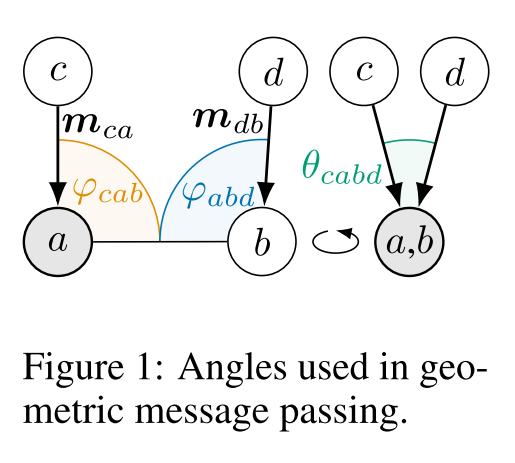

You can train a GemNet-T (T = triplets) on S2EF-200k using the following config.

Note that this is a significantly bulkier model (~3.4M params) than the one we developed above and will take longer to train.

In [ ]:
model_params = {
    'name': 'gemnet_t',
    'num_spherical': 7,
    'num_radial': 128,
    'num_blocks': 1,
    'emb_size_atom': 256,
    'emb_size_edge': 256,
    'emb_size_trip': 64,
    'emb_size_rbf': 16,
    'emb_size_cbf': 16,
    'emb_size_bil_trip': 64,
    'num_before_skip': 1,
    'num_after_skip': 1,
    'num_concat': 1,
    'num_atom': 3,
    'cutoff': 6.0,
    'max_neighbors': 50,
    'rbf': {'name': 'gaussian'},
    'envelope': {'name': 'polynomial', 'exponent': 5},
    'cbf': {'name': 'spherical_harmonics'},
    'extensive': True,
    'otf_graph': False,
    'output_init': 'HeOrthogonal',
    'activation': 'silu',
    'scale_file': 'configs/s2ef/all/gemnet/scaling_factors/gemnet-dT.json',
    'regress_forces': True,
    'direct_forces': True,
}

trainer = OCPTrainer(
    task=task,
    model=model_params,
    dataset=dataset,
    optimizer=optimizer,
    outputs={},
    loss_fns={},
    eval_metrics={},
    name="s2ef",
    identifier="S2EF-gemnet-t",
    run_dir="./", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0, # random seed to use
    logger="tensorboard", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage),
)

trainer.train()

This model should achieve a force MAE of 0.0668, a force cosine of 0.1180, and an energy MAE of 0.8106 in 2 epochs, significantly better than our simple model.

Again, we encourage the reader to try playing with no. of blocks, choice of basis functions, the various embedding sizes to develop intuition for the interplay between these hyperparameters.

# (Optional) OCP Calculator <a name="calc"></a>

For those interested in using our pretrained models for other applications, we provide an [ASE](https://wiki.fysik.dtu.dk/ase/#:~:text=The%20Atomic%20Simulation%20Environment%20(ASE,under%20the%20GNU%20LGPL%20license.)-compatible Calculator to interface with ASE's functionality.

## Download pretrained checkpoint

We have released checkpoints of all the models on the leaderboard [here](https://github.com/Open-Catalyst-Project/ocp/blob/master/MODELS.md). These trained models can be used as an ASE calculator for various calculations.

For this tutorial we download our current best model checkpoint: GemNet-T

In [ ]:
!wget -q https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt
checkpoint_path = "/content/ocp/gemnet_t_direct_h512_all.pt"

## Using the OCP Calculator


In [ ]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import BFGS
from ase.build import fcc100, add_adsorbate, molecule
import os
from ase.constraints import FixAtoms

# Construct a sample structure
adslab = fcc100("Cu", size=(3, 3, 3))
adsorbate = molecule("C3H8")
add_adsorbate(adslab, adsorbate, 3, offset=(1, 1))
tags = np.zeros(len(adslab))
tags[18:27] = 1
tags[27:] = 2
adslab.set_tags(tags)
cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
adslab.set_constraint(cons)
adslab.center(vacuum=13.0, axis=2)
adslab.set_pbc(True)

# Define the calculator
calc = OCPCalculator(checkpoint_path=checkpoint_path)

# Set up the calculator
adslab.calc = calc

os.makedirs("data/sample_ml_relax", exist_ok=True)
opt = BFGS(adslab, trajectory="data/sample_ml_relax/toy_c3h8_relax.traj")

opt.run(fmax=0.05, steps=100)

<a name="lmdb"></a>
# (Optional) Creating your own LMDBs for use in the OCP repository 

In order to interface with our repository, the data mustbe structured and organized in a specific format. Below we walk you through on how to create such datasets with your own non-OC20 data that may help with your research.

For this tutorial we use the toy C3H8 trajectory we previously generated [here](#data-description).



#### Initial Structure to Relaxed Energy (IS2RE) LMDBs
IS2RE/IS2RS LMDBs utilize the LmdbDataset dataset. This dataset expects the data to be contained in a **single** LMDB file. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the IS2RE/IS2RS tasks:

- pos_relaxed: Relaxed adslab positions
- sid: Unique system identifier, arbitrary
- y_init: Initial adslab energy, formerly Data.y
- y_relaxed: Relaxed adslab energy
- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate


As a demo, we will use the above generated data to create an IS2R* LMDB file.


In [ ]:
from ocpmodels.preprocessing import AtomsToGraphs

"""
args description:

max neigh (int): maximum number of neighors to be considered while constructing a graph
radius (int): Neighbors are considered only within this radius cutoff in Angstrom
r_energy (bool): Stored energy value in the Data object; False for test data
r_forces (bool): Stores forces value in the Data object; False for test data
r_distances (bool): pre-calculates distances taking into account PBC and max neigh/radius
  If you set it to False, make sure to add "otf_graph = True" under models in config for runs
r_fixed (bools): True if you want to fix the subsurface atoms
"""

a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=True,    
    r_forces=True,
    r_distances=False, 
    r_fixed=True,
)

In [ ]:
import lmdb

"""
For most cases one just needs to change the name of the lmdb as they require.
Make sure to give the entire path in the config (with .lmdb) for IS2RE tasks
"""

db = lmdb.open(
    "data/toy_C3H8.lmdb",
    map_size=1099511627776 * 2,
    subdir=False,
    meminit=False,
    map_async=True,
)

In [ ]:
"""
This method converts extracts all features from trajectory file and convert to Data Object
"""

def read_trajectory_extract_features(a2g, traj_path):
    # Read the traj file
    traj = ase.io.read(traj_path, ":")

    # Get tags if you had defined those in the atoms object, if not skip this line
    tags = traj[0].get_tags()

    # Collect only initial and final image as this is IS2RS task
    images = [traj[0], traj[-1]]

    # Converts a list of atoms object to a list of Data object using a2g defined above
    data_objects = a2g.convert_all(images, disable_tqdm=True)

    # Add tags to the data objects if you have them (we would suggest to do so), if not skip this
    data_objects[0].tags = torch.LongTensor(tags)
    data_objects[1].tags = torch.LongTensor(tags)

    return data_objects

In [ ]:
import torch
import pickle
system_paths = ["data/toy_c3h8_relax.traj"] # specify list of trajectory files you wish to write to LMDBs
idx = 0

for system in system_paths:
    # Extract Data object
    data_objects = read_trajectory_extract_features(a2g, system)
    initial_struc = data_objects[0]
    relaxed_struc = data_objects[1]
    
    initial_struc.y_init = initial_struc.y # subtract off reference energy, if applicable
    del initial_struc.y
    initial_struc.y_relaxed = relaxed_struc.y # subtract off reference energy, if applicable
    initial_struc.pos_relaxed = relaxed_struc.pos
    
    # Filter data if necessary
    # OCP filters adsorption energies > |10| eV
    
    initial_struc.sid = idx  # arbitrary unique identifier 
    
    # no neighbor edge case check
    if initial_struc.edge_index.shape[1] == 0:
        print("no neighbors", traj_path)
        continue
    
    # Write to LMDB
    txn = db.begin(write=True)
    txn.put(f"{idx}".encode("ascii"), pickle.dumps(initial_struc, protocol=-1))
    txn.commit()
    db.sync()
    idx += 1

db.close()

In [ ]:
from ocpmodels.datasets import LmdbDataset

# LmdbDataset is out custom Dataset method to read the lmdbs as Data objects. Note that we need to give the entire path (including lmdb) for IS2RE
dataset = LmdbDataset({"src": "data/toy_C3H8.lmdb"})

print("Size of the dataset created:", len(dataset))
print(dataset[0])

#### Structure to Energy and Forces (S2EF) LMDBs

S2EF LMDBs utilize the LmdbDatset dataset. This dataset expects a directory of LMDB files. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the S2EF task:

- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate
- fid: Frame index along the trajcetory
- sid- sid: Unique system identifier, arbitrary

Additionally, a "length" key must be added to each LMDB file.

As a demo, we will use the above generated data to create an S2EF LMDB dataset

In [ ]:
os.makedirs("data/s2ef", exist_ok=True)
db = lmdb.open(
    "data/s2ef/toy_C3H8.lmdb",
    map_size=1099511627776 * 2,
    subdir=False,
    meminit=False,
    map_async=True,
)

In [ ]:
from tqdm import tqdm
tags = traj[0].get_tags()
data_objects = a2g.convert_all(traj, disable_tqdm=True)


for fid, data in tqdm(enumerate(data_objects), total=len(data_objects)):
    #assign sid
    data.sid = torch.LongTensor([0])
    
    #assign fid
    data.fid = torch.LongTensor([fid])
    
    #assign tags, if available
    data.tags = torch.LongTensor(tags)
    
    # Filter data if necessary
    # OCP filters adsorption energies > |10| eV and forces > |50| eV/A

    # no neighbor edge case check
    if data.edge_index.shape[1] == 0:
        print("no neighbors", traj_path)
        continue

    txn = db.begin(write=True)
    txn.put(f"{fid}".encode("ascii"), pickle.dumps(data, protocol=-1))
    txn.commit()
    
txn = db.begin(write=True)
txn.put(f"length".encode("ascii"), pickle.dumps(len(data_objects), protocol=-1))
txn.commit()


db.sync()
db.close()

# Running on command line [Preferred way to train models] <a name="cmd"></a>

The previous sections of this notebook are intended to demonstrate the inner workings of our codebase. For regular training, we suggest that you train and evaluate on command line.

1. Clone our repo at https://github.com/Open-Catalyst-Project/ocp and set up the environment according to the readme.
2. Download relevant data ([see above for info](https://colab.research.google.com/drive/1oGZcrakB4Pbj8Xq74lSvcRDUHw9L-Dh5#scrollTo=jXoiLncsU3pe)).


3. In the config file, modify the path of the data [train](https://github.com/Open-Catalyst-Project/ocp/blob/master/configs/is2re/10k/base.yml#L4) [val](https://github.com/Open-Catalyst-Project/ocp/blob/master/configs/is2re/10k/base.yml#L8), [normalization parameters](https://github.com/Open-Catalyst-Project/ocp/blob/master/configs/is2re/10k/base.yml#L5-L7)  as well as any other [model](https://github.com/Open-Catalyst-Project/ocp/blob/master/configs/is2re/10k/dimenet_plus_plus/dpp.yml#L4-L16) or [training](https://github.com/Open-Catalyst-Project/ocp/blob/master/configs/is2re/10k/dimenet_plus_plus/dpp.yml#L23-L35) args. 

For a simple example, we'll train DimeNet++ on IS2RE demo data: \
a. Modify the train data path in `/contents/ocp/configs/is2re/10k/base.yml` in 
Line 4 to `/contents/ocp/data/is2re/train_10k/data.lmdb` and val data path in Line 8 to `/contents/ocp/data/is2re/val_2k/data.lmdb`. \
b. Calculate the mean and std for train data and modify Lines 6-7 respectively \
c. We can change the model parameters in `/contents/ocp/configs/is2re/10k/dimenet_plus_plus/dpp.yml` and we suggest you to change the lr_milestones and warmup_steps as the data here is smaller (these need to be tuned for every dataset).


4. Train: `python main.py --mode train --config-yml configs/is2re/10k/dimenet_plus_plus/dpp.yml --identifier dpp_is2re_sample`


In [ ]:
# Optional block to try command line training 
# Note that config args can be added in the command line. For example, --optim.batch_size=1

5. Add a data path as a test set to `configs/is2re/10k/base.yml`
6. Run predictions with the trained model: 
`python main.py --mode predict --config-yml configs/is2re/10k/dimenet_plus_plus/dpp.yml --checkpoint checkpoints/[datetime]-dpp_is2re_sample/checkpoint.pt`
7. View energy predictions at `results/[datetime]/is2re_predictions.npz`

For more information on how to train and evaluate, see [this readme](https://github.com/Open-Catalyst-Project/ocp/blob/master/TRAIN.md). For checkpoints of publicly available trained models, see [MODELS.md](https://github.com/Open-Catalyst-Project/ocp/blob/master/MODELS.md).

# Limitations <a name="limit"></a>
The OpenCatalyst project is motivated by the problems we face due to climate change, many of which require innovative solutions to reduce energy usage and replace traditional chemical feedstocks with renewable alternatives. For example, one of the most energy intensive chemical processes is the development of new electrochemical catalysts for ammonia fertilizer production that helped to feed the world’s growing population during the 20th century. This is also an illustrative example of possible unintended consequences as advancements in chemistry and materials may be used for numerous purposes. As ammonia fertilization increased in use, its overuse in today’s farming has led to ocean “dead zones” and its production is very carbon intensive. Knowledge and techniques used to create ammonia were also transferred to the creation of explosives during wartime. We hope to steer the use of ML for atomic simulations to societally-beneficial uses by training and testing our approaches on datasets, such as OC20, that were specifically designed to address chemical reactions useful for addressing climate change.

# Next Steps <a name="steps"></a>

While progress has been well underway - https://opencatalystproject.org/leaderboard.html, a considerable gap still exists between state-of-the-art models and our target goals. We offer some some general thoughts as to next steps for the readers to ponder on or explore:

* GNN depth has consistenly improved model performance. What limitations to depth are there? How far can we push deeper models for OC20? 
* Our best performing models have little to no physical biases encoded. Can we incorporate such biases to improve our models? Experiments with physically inspired embeddings have had no advantage vs. random initializations, are there better ways to incorporate this information into the models?
* Uncertainty estimation will play an important role in later stages of the project when it comes to large scale screening. How can we get reliable uncertainty estimates from large scale GNNs?
* Are we limited to message-passing GNNs? Can we leverage alternative architectures for similiar or better performance?
* Trajectories are nothing more than sequential data points. How can we use sequential modeling techniques to model the full trajectory?

OC20 is a large and diverse dataset with many splits. For those with limited resources but unsure where to start, we provide some general recommendations:

* The IS2RE-direct task is a great place to start. With the largest training set containing ~460k data points, this task is easily accesible for those with even just a single GPU.
* Those interested in the more general S2EF task don't need to train on the All set to get meaningful performance.
    * Results on the 2M dataset are often sufficient to highlight model improvements.
    * For a fixed compute budget (e.g. fixed number of steps), training on the All set often leads to better performance.
* The S2EF 200k dataset is fairly noisy, trying to find meaningful trends using this dataset can be difficult.



<a name="references"></a>
# References

* Open Catalyst codebase: https://github.com/Open-Catalyst-Project/ocp/
* Open Catalyst webpage: https://opencatalystproject.org/
* [Electrocatalysis white paper](https://arxiv.org/pdf/2010.09435.pdf): C. Lawrence Zitnick, Lowik Chanussot, Abhishek Das, Siddharth Goyal, Javier Heras-Domingo, Caleb Ho, Weihua Hu, Thibaut Lavril, Aini Palizhati, Morgane Riviere, Muhammed Shuaibi, Anuroop Sriram, Kevin Tran, Brandon Wood, Junwoong Yoon, Devi Parikh, Zachary Ulissi: “An Introduction to Electrocatalyst Design using Machine Learning for Renewable Energy Storage”, 2020; arXiv:2010.09435.
* [OC20 dataset paper](https://arxiv.org/pdf/2010.09990.pdf): L. Chanussot, A. Das, S. Goyal, T. Lavril, M. Shuaibi, M. Riviere, K. Tran, J. Heras-Domingo, C. Ho, W. Hu, A. Palizhati, A. Sriram, B. Wood, J. Yoon, D. Parikh, C. L. Zitnick, and Z. Ulissi. The Open Catalyst 2020 (oc20) dataset and community challenges. ACS Catalysis, 2021.
* [Gemnet model:](https://arxiv.org/abs/2106.08903) Johannes Klicpera, Florian Becker, and Stephan Günnemann. Gemnet: Universal directional graph neural networks for molecules, 2021.


